# Training

In [26]:
import time

In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

In [48]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [29]:
from src.starcattovae.training.data import Data

from src.starcattovae.nn.vae import VAE

from src.starcattovae.plotting import plot_loss
from src.starcattovae.plotting import plot_individual_loss
from src.starcattovae.plotting import plot_training_validation_loss
from src.starcattovae.plotting import plot_reconstruction
from src.starcattovae.plotting import plot_waveform_grid
from src.starcattovae.plotting import plot_latent_morphs
from src.starcattovae.plotting import plot_signal_distribution

In [30]:
manualSeed = 99
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # reproducibility

### Define Parameters

In [ ]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# model parameters
batch_size = 32
epochs = 100

x_length = 256
hidden_dim = 512
latent_dim = 8
lr = 1e-3

Using device: mps


## Load Training Data

In [32]:
np.random.seed(42)
indices = np.arange(1684) # this is the number of signals minus all the signals with beta_IC_b less than 0
np.random.shuffle(indices)
split_ratio = 0.9
split_idx = int(len(indices) * split_ratio)
train_indices = indices[:split_idx]
validation_indices = indices[split_idx:]

# Create train and validation datasets
train_dataset = Data(indices=train_indices, train=True)
validation_dataset = Data(indices=validation_indices, train=False)

# Check for overlap
train_indices_set = set(train_dataset.get_indices())
validation_indices_set = set(validation_dataset.get_indices())

overlap = train_indices_set.intersection(validation_indices_set)
if len(overlap) == 0:
    print("Train and validation sets are different.")
else:
    print("Train and validation sets have overlap.")

Train and validation sets are different.


In [33]:
train_dataset.summary()
validation_dataset.summary()

2024-11-18 23:59:15.655 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.524 +/- 39.879
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 656.2575073242188
Signal Dataset shape: (256, 1515)

2024-11-18 23:59:15.657 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.444 +/- 38.309
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 626.9296875
Signal Dataset shape: (256, 169)



In [34]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Load VAE

In [35]:
model = VAE(input_dim=x_length, hidden_dim=hidden_dim, latent_dim=latent_dim, DEVICE=DEVICE).to(DEVICE)

### Loss Function

In [36]:
def loss_function(x, x_hat, mean, log_var):
    # sse loss
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    reproduction_loss *= 1 * x.shape[1]
    
    # KL Divergence loss
    kld_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    # total loss
    total_loss = reproduction_loss + kld_loss

    return total_loss, reproduction_loss, kld_loss

optimizer = Adam(model.parameters(), lr=lr)

### Train VAE

Start training VAE...


Training:   1%|          | 1/100 [00:00<01:05,  1.52it/s]

Epoch 1, Train Loss: 204.3756, Val Loss: 130.7118


Training:   2%|▏         | 2/100 [00:01<01:04,  1.52it/s]

Epoch 2, Train Loss: 108.3741, Val Loss: 99.0407


Training:   3%|▎         | 3/100 [00:02<01:06,  1.46it/s]

Epoch 3, Train Loss: 79.7442, Val Loss: 70.0495


Training:   4%|▍         | 4/100 [00:02<01:05,  1.47it/s]

Epoch 4, Train Loss: 64.2981, Val Loss: 65.9595


Training:   5%|▌         | 5/100 [00:03<01:04,  1.47it/s]

Epoch 5, Train Loss: 59.2806, Val Loss: 60.4905


Training:   6%|▌         | 6/100 [00:04<01:03,  1.48it/s]

Epoch 6, Train Loss: 53.8782, Val Loss: 54.0488


Training:   7%|▋         | 7/100 [00:04<01:02,  1.49it/s]

Epoch 7, Train Loss: 49.2244, Val Loss: 52.1575


Training:   8%|▊         | 8/100 [00:05<01:05,  1.40it/s]

Epoch 8, Train Loss: 47.4582, Val Loss: 49.2005


Training:   9%|▉         | 9/100 [00:06<01:04,  1.42it/s]

Epoch 9, Train Loss: 45.8261, Val Loss: 49.0656


Training:   9%|▉         | 9/100 [00:06<01:04,  1.42it/s]

Epoch 10, Train Loss: 44.7817, Val Loss: 49.5620


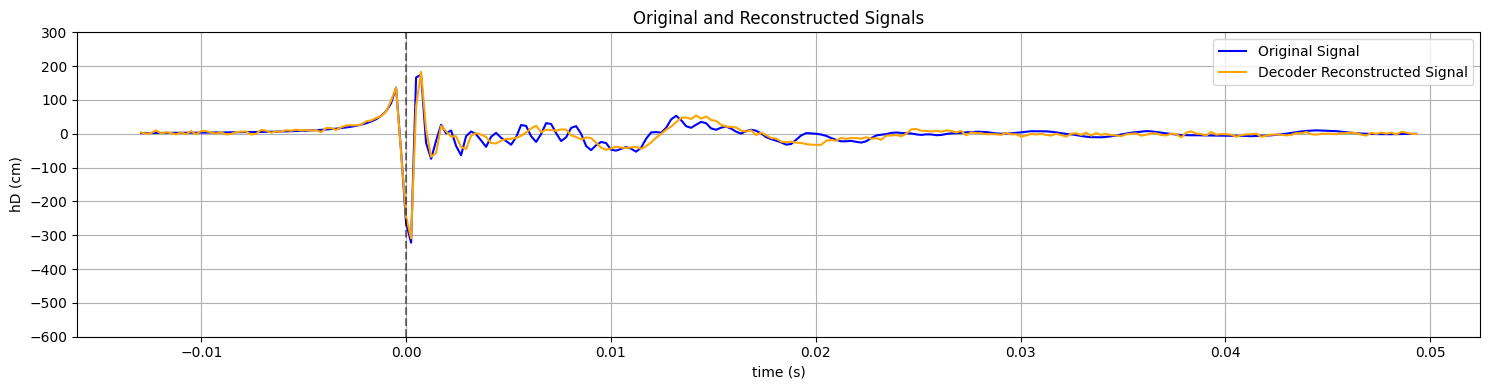

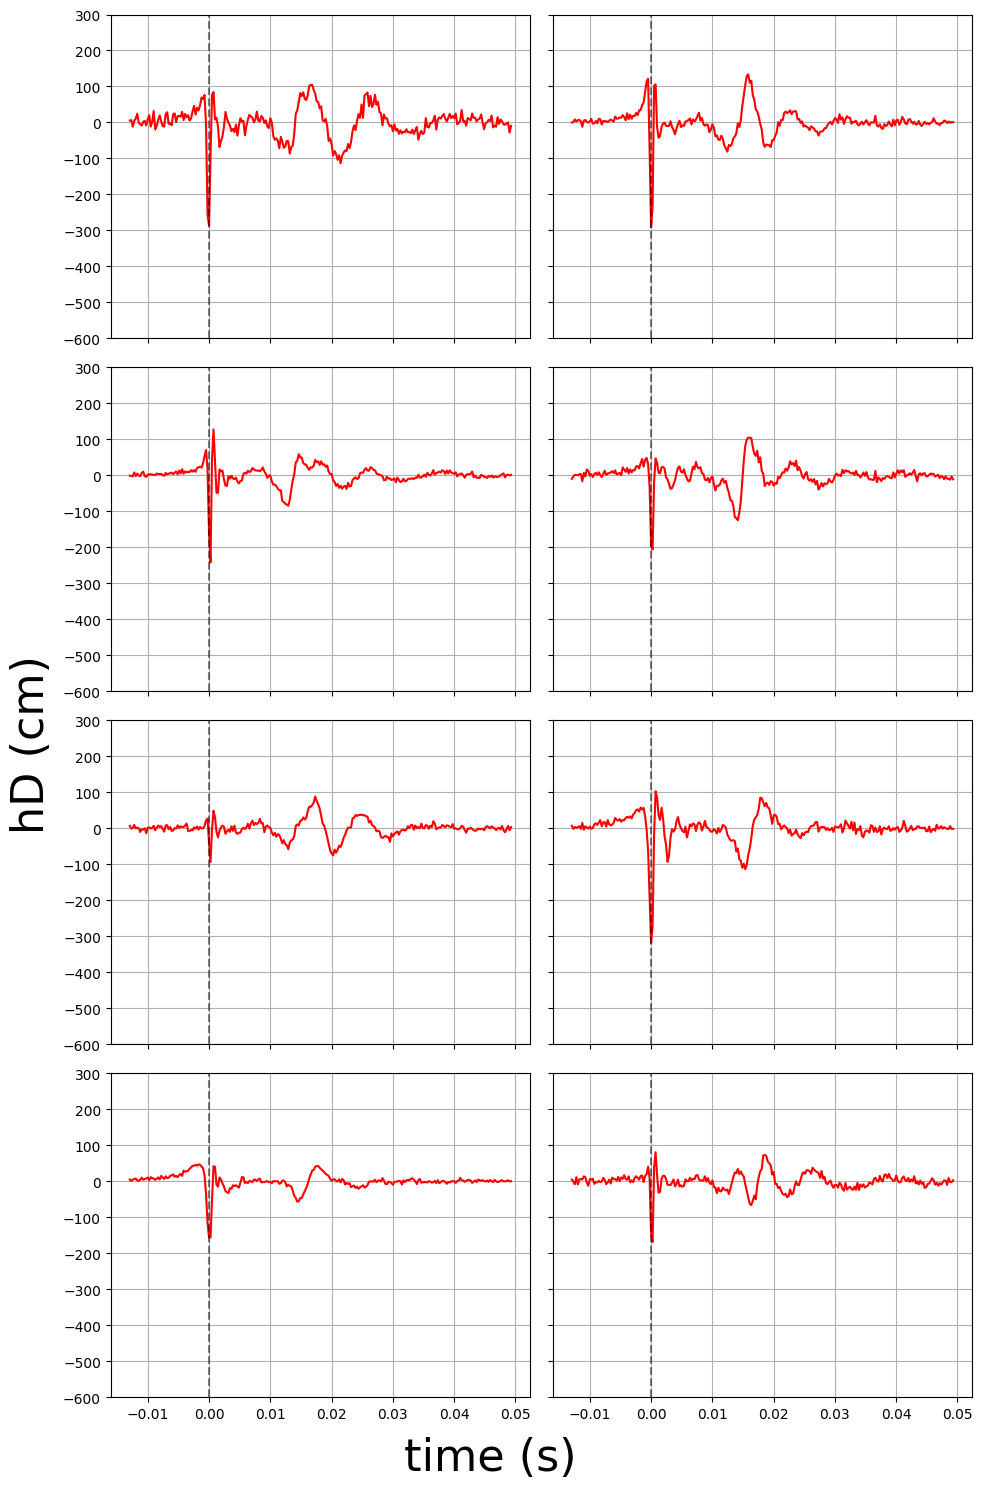

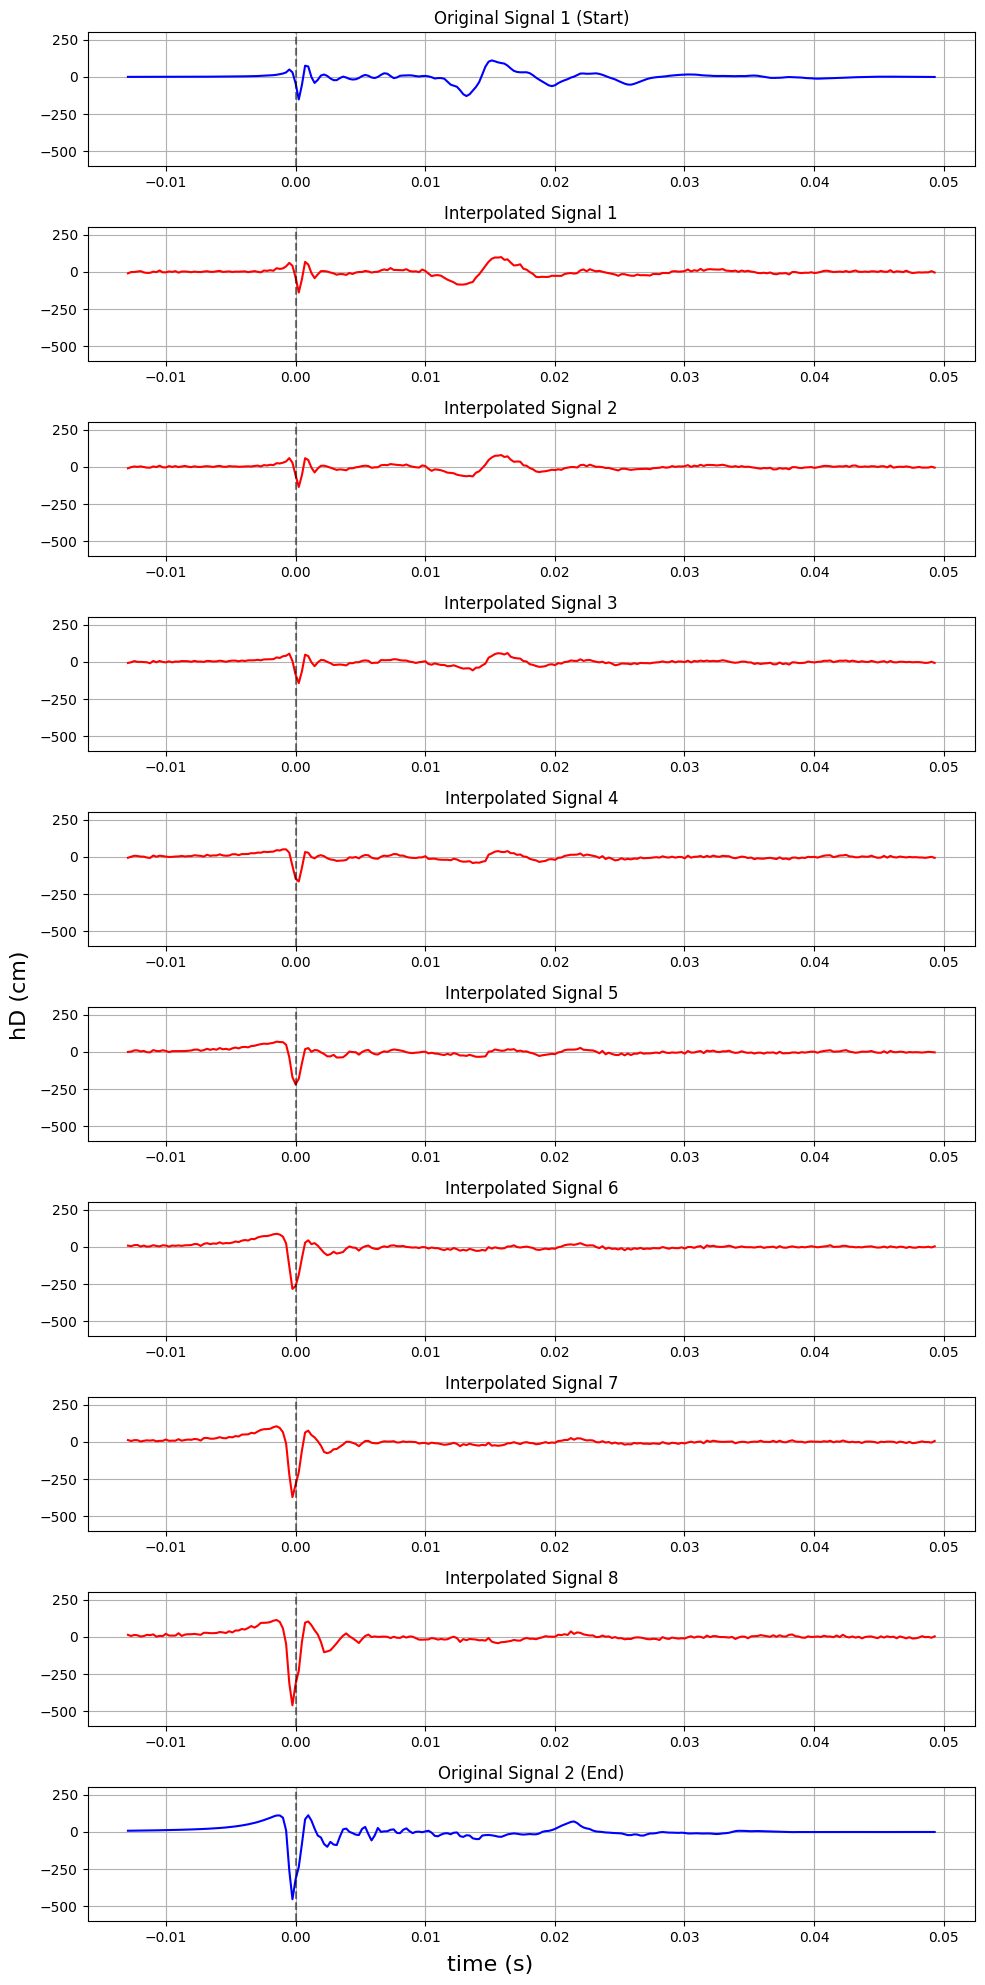

Training:  11%|█         | 11/100 [00:08<01:24,  1.05it/s]

Epoch 11, Train Loss: 44.0815, Val Loss: 48.0561


Training:  12%|█▏        | 12/100 [00:09<01:18,  1.12it/s]

Epoch 12, Train Loss: 43.4977, Val Loss: 45.8299


Training:  13%|█▎        | 13/100 [00:10<01:13,  1.18it/s]

Epoch 13, Train Loss: 41.8538, Val Loss: 46.2312


Training:  14%|█▍        | 14/100 [00:10<01:07,  1.27it/s]

Epoch 14, Train Loss: 41.6917, Val Loss: 46.5190


Training:  15%|█▌        | 15/100 [00:11<01:03,  1.34it/s]

Epoch 15, Train Loss: 41.1717, Val Loss: 45.4357


Training:  16%|█▌        | 16/100 [00:12<01:00,  1.39it/s]

Epoch 16, Train Loss: 40.4028, Val Loss: 44.7236


Training:  17%|█▋        | 17/100 [00:12<00:59,  1.38it/s]

Epoch 17, Train Loss: 40.2428, Val Loss: 46.1321


Training:  18%|█▊        | 18/100 [00:13<00:57,  1.42it/s]

Epoch 18, Train Loss: 39.6821, Val Loss: 44.7836


Training:  19%|█▉        | 19/100 [00:14<00:56,  1.43it/s]

Epoch 19, Train Loss: 39.5565, Val Loss: 44.0896


Training:  19%|█▉        | 19/100 [00:14<00:56,  1.43it/s]

Epoch 20, Train Loss: 38.4943, Val Loss: 41.9601


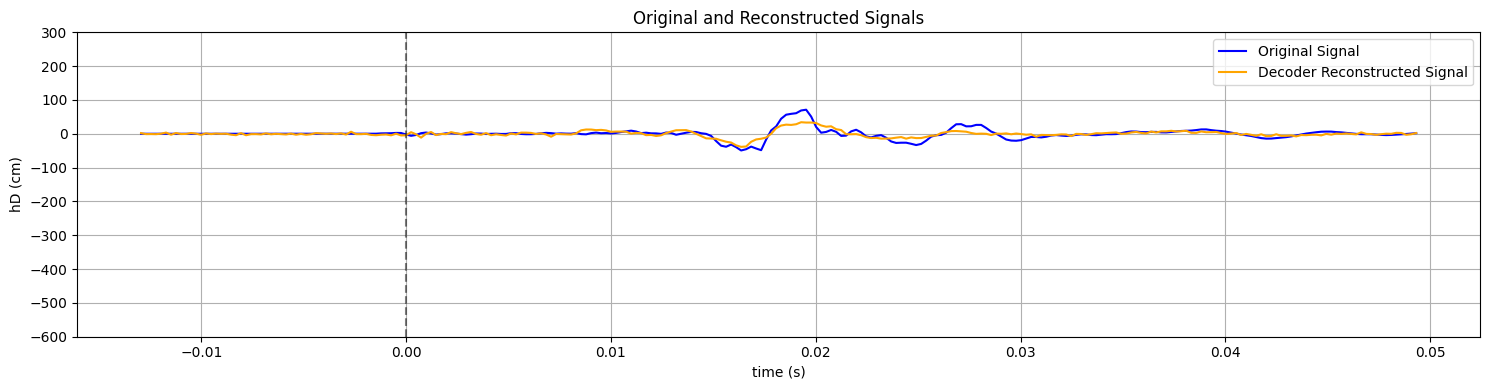

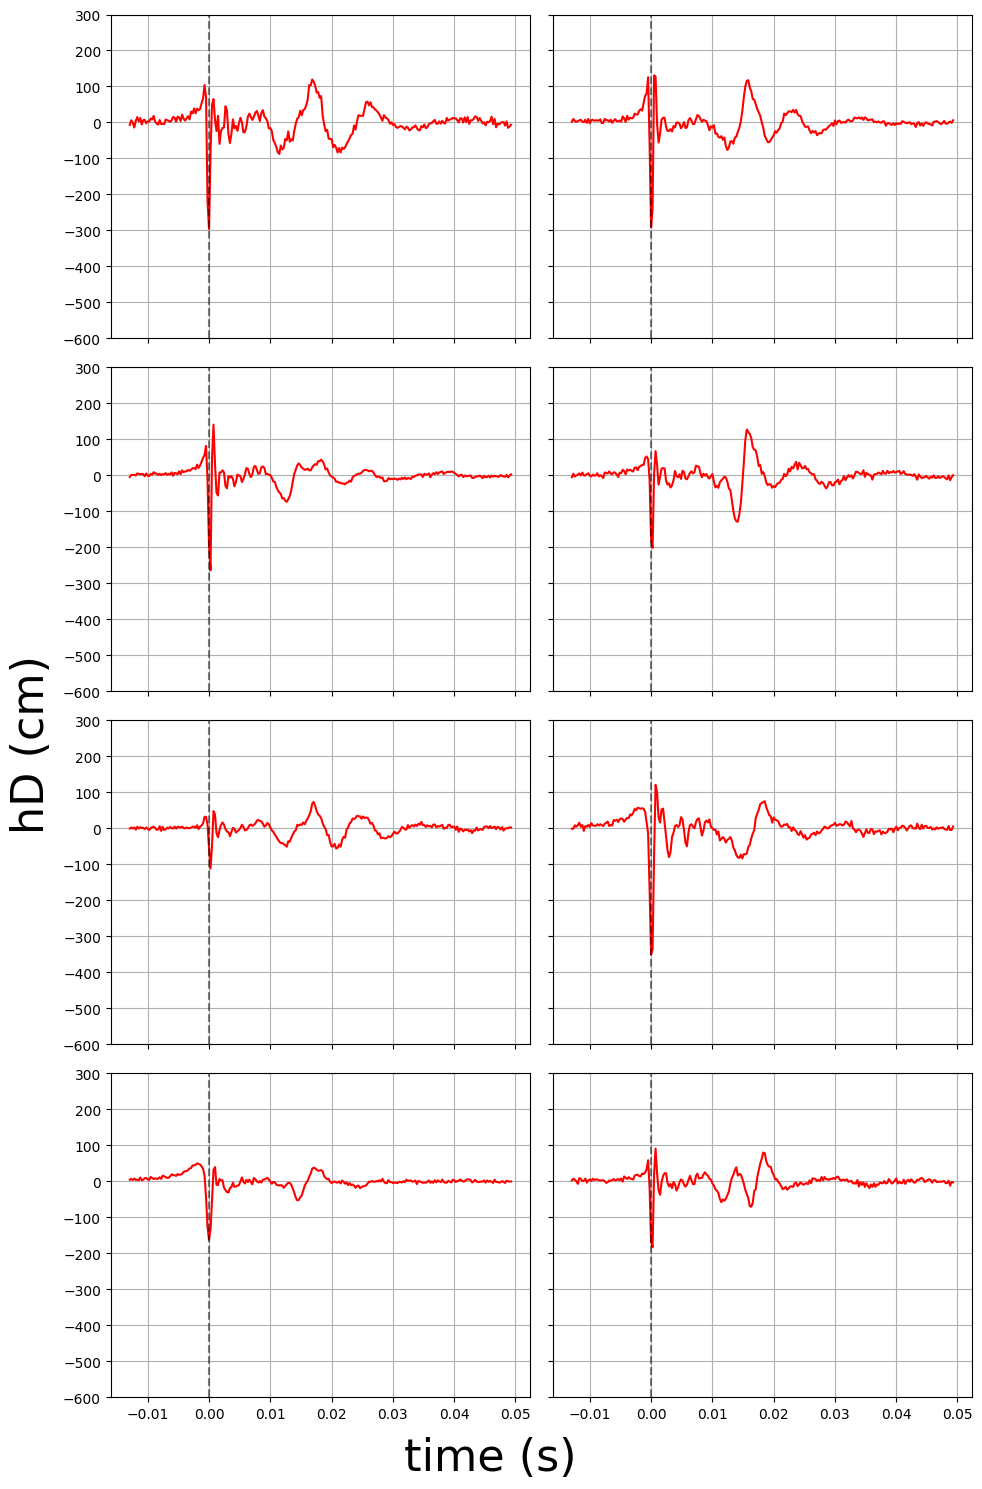

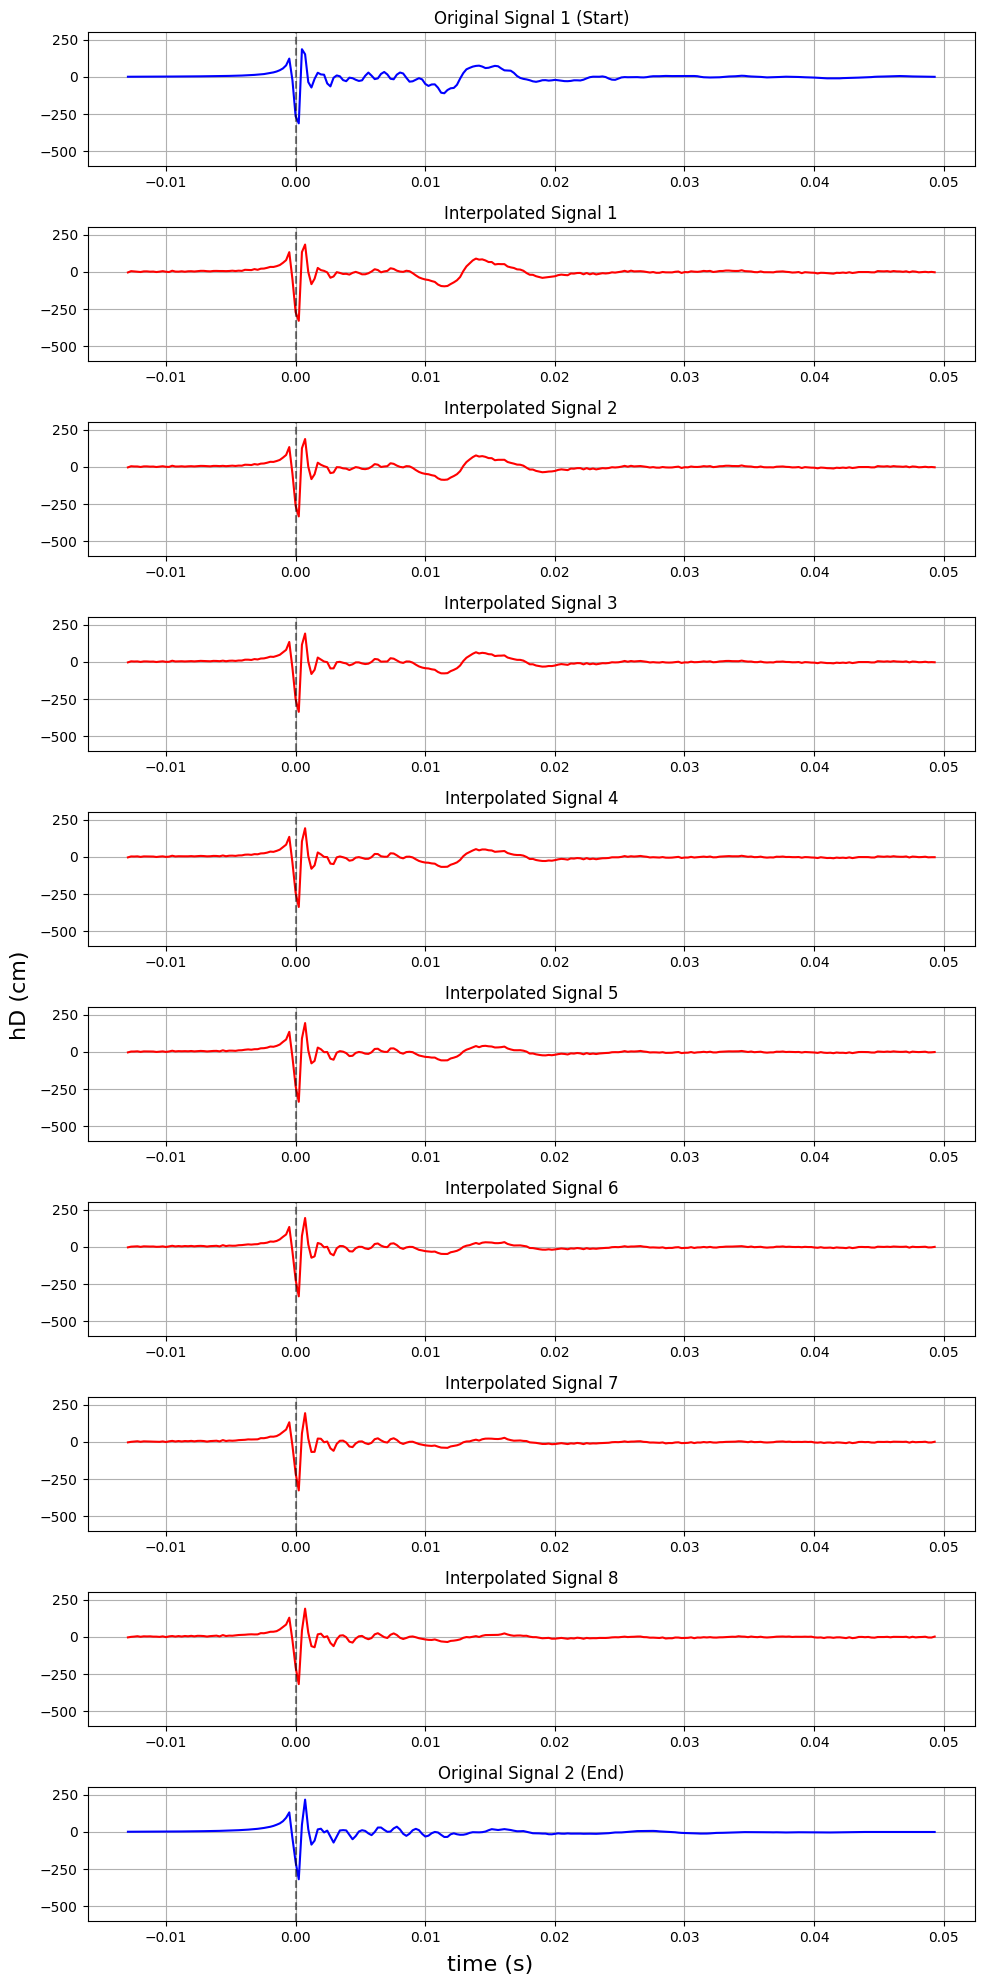

Training:  21%|██        | 21/100 [00:17<01:19,  1.01s/it]

Epoch 21, Train Loss: 38.5726, Val Loss: 42.1623


Training:  22%|██▏       | 22/100 [00:17<01:12,  1.08it/s]

Epoch 22, Train Loss: 38.4592, Val Loss: 42.7871


Training:  23%|██▎       | 23/100 [00:18<01:06,  1.15it/s]

Epoch 23, Train Loss: 37.7566, Val Loss: 42.3880


Training:  24%|██▍       | 24/100 [00:19<01:04,  1.18it/s]

Epoch 24, Train Loss: 37.9633, Val Loss: 43.7038


Training:  25%|██▌       | 25/100 [00:20<00:59,  1.27it/s]

Epoch 25, Train Loss: 37.1424, Val Loss: 41.8729


Training:  26%|██▌       | 26/100 [00:20<00:55,  1.33it/s]

Epoch 26, Train Loss: 37.1236, Val Loss: 41.4167


Training:  27%|██▋       | 27/100 [00:21<00:55,  1.33it/s]

Epoch 27, Train Loss: 36.5650, Val Loss: 40.8887


Training:  28%|██▊       | 28/100 [00:22<00:52,  1.38it/s]

Epoch 28, Train Loss: 36.0620, Val Loss: 41.0075


Training:  29%|██▉       | 29/100 [00:22<00:50,  1.42it/s]

Epoch 29, Train Loss: 36.3116, Val Loss: 40.7895


Training:  29%|██▉       | 29/100 [00:23<00:50,  1.42it/s]

Epoch 30, Train Loss: 35.8080, Val Loss: 40.1991


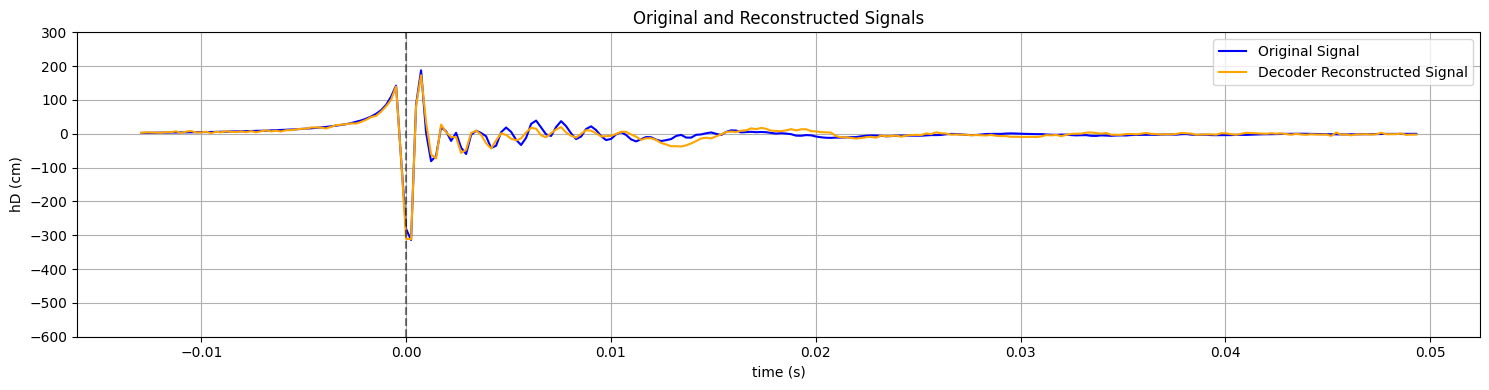

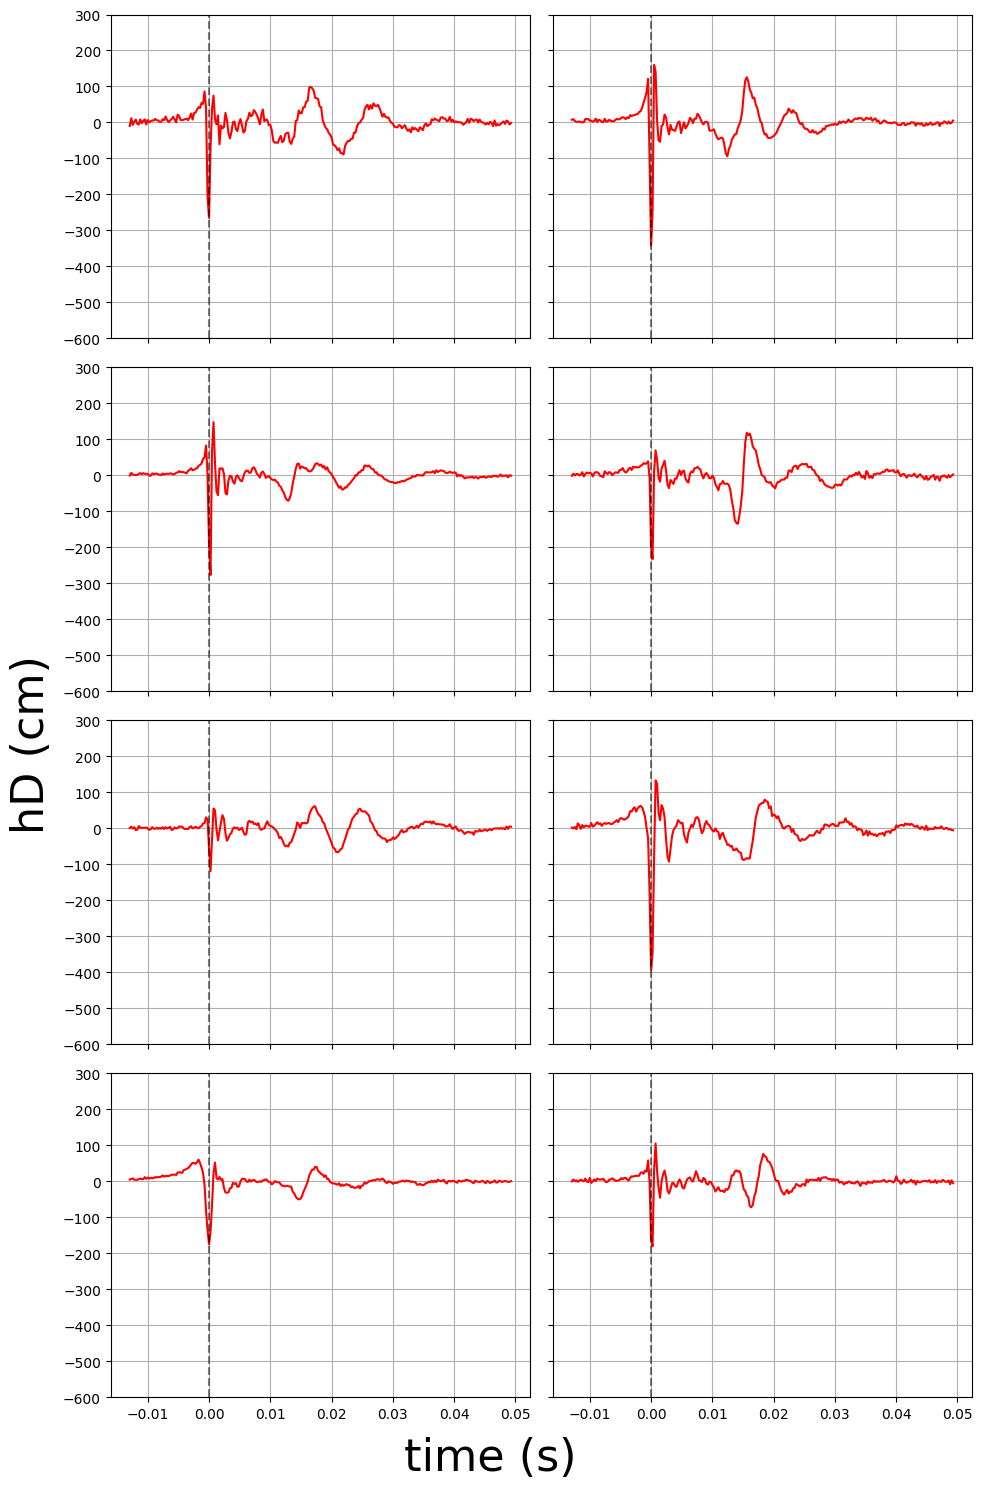

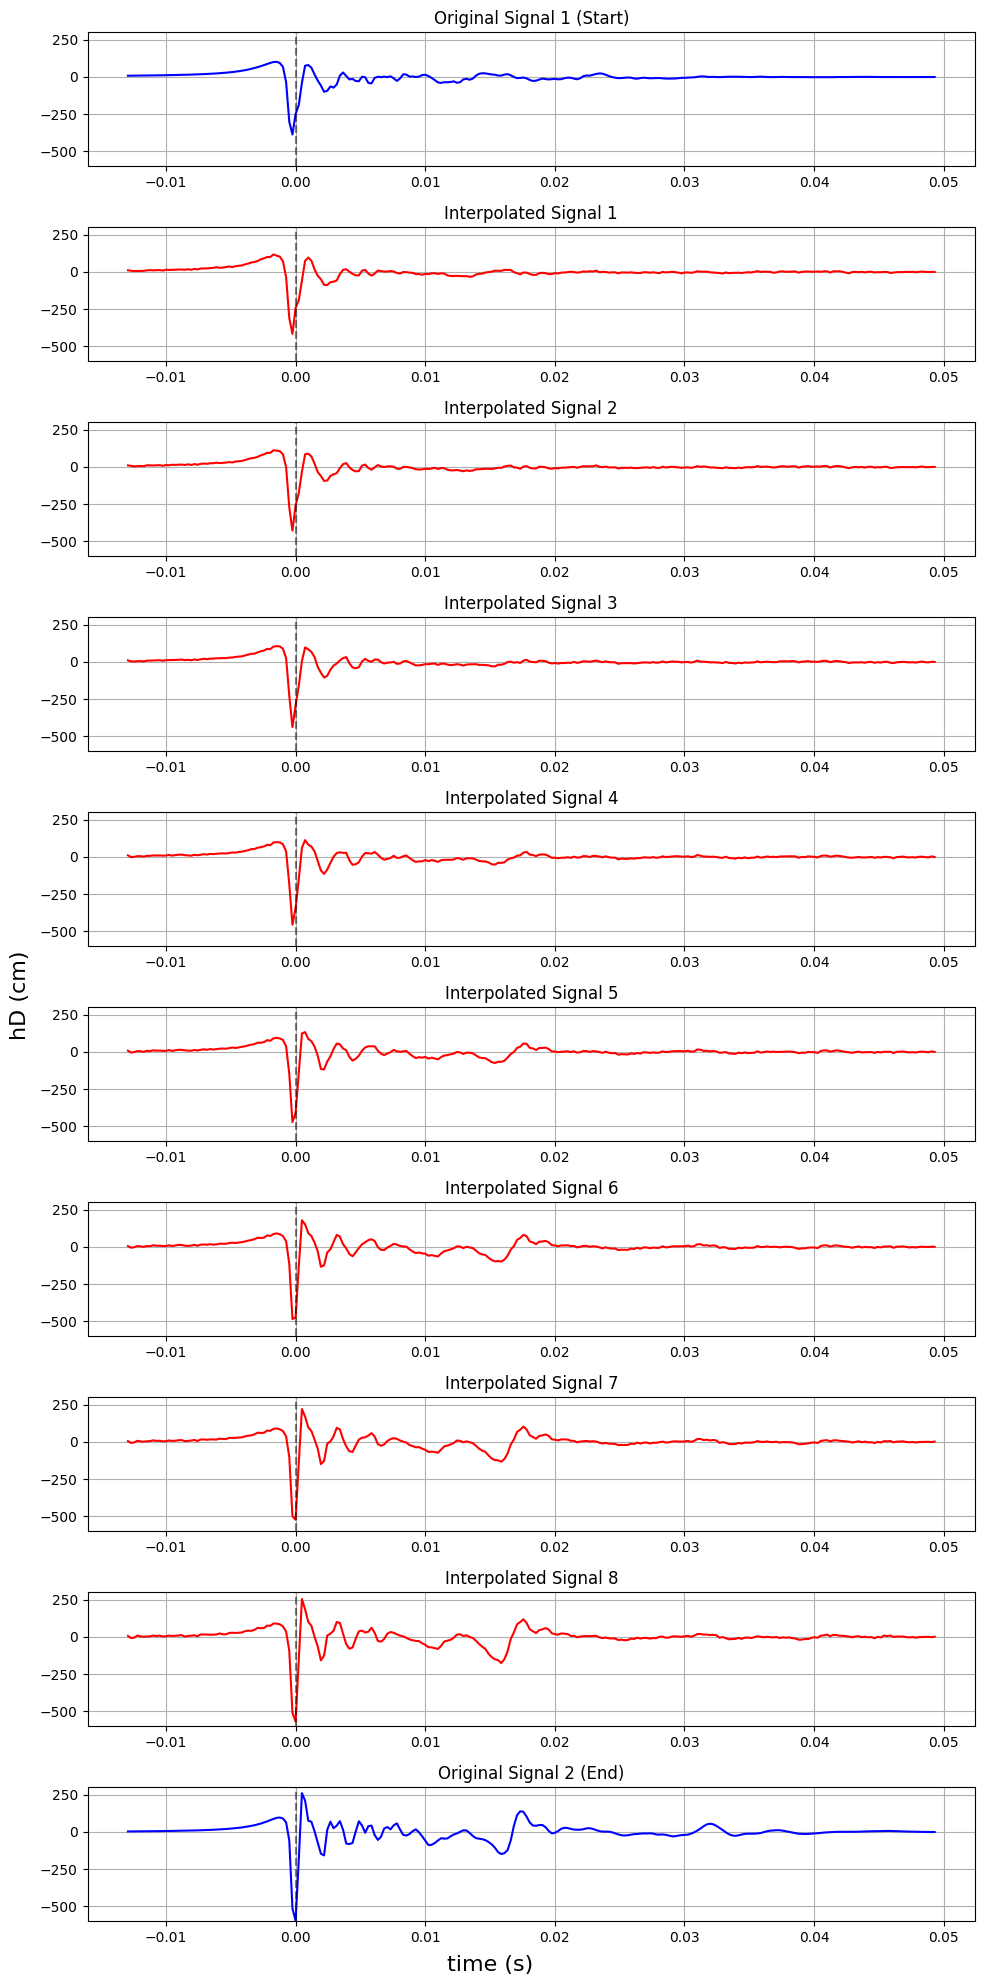

Training:  31%|███       | 31/100 [00:25<01:04,  1.06it/s]

Epoch 31, Train Loss: 35.0071, Val Loss: 39.4221


Training:  32%|███▏      | 32/100 [00:26<00:58,  1.16it/s]

Epoch 32, Train Loss: 35.2483, Val Loss: 40.0656


Training:  33%|███▎      | 33/100 [00:26<00:53,  1.25it/s]

Epoch 33, Train Loss: 34.8920, Val Loss: 39.5093


Training:  34%|███▍      | 34/100 [00:27<00:50,  1.29it/s]

Epoch 34, Train Loss: 34.2650, Val Loss: 39.3634


Training:  35%|███▌      | 35/100 [00:28<00:48,  1.35it/s]

Epoch 35, Train Loss: 34.3684, Val Loss: 40.4066


Training:  36%|███▌      | 36/100 [00:28<00:45,  1.40it/s]

Epoch 36, Train Loss: 33.7896, Val Loss: 39.8471


Training:  37%|███▋      | 37/100 [00:29<00:43,  1.44it/s]

Epoch 37, Train Loss: 34.3117, Val Loss: 38.9812


Training:  38%|███▊      | 38/100 [00:30<00:42,  1.45it/s]

Epoch 38, Train Loss: 34.0923, Val Loss: 39.6864


Training:  39%|███▉      | 39/100 [00:30<00:41,  1.46it/s]

Epoch 39, Train Loss: 33.8965, Val Loss: 39.3059


Training:  39%|███▉      | 39/100 [00:31<00:41,  1.46it/s]

Epoch 40, Train Loss: 33.6436, Val Loss: 38.4435


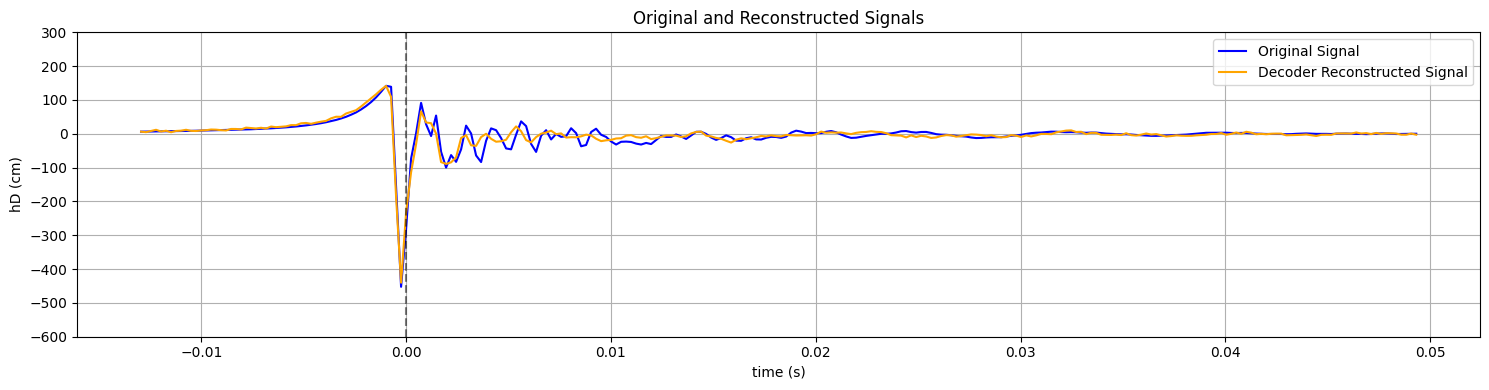

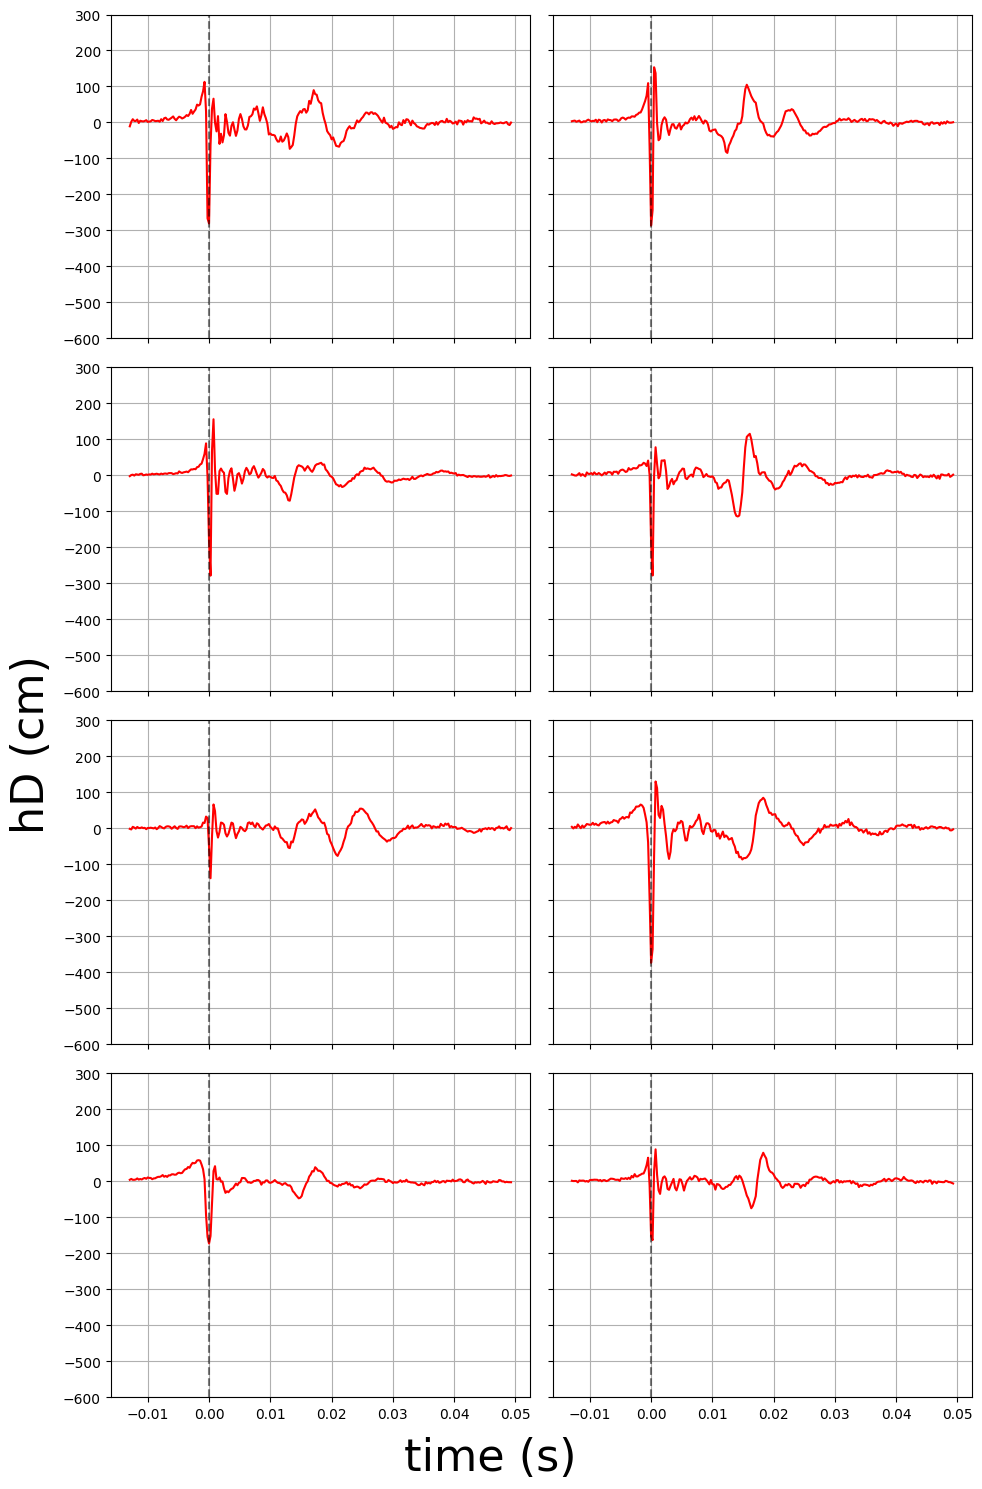

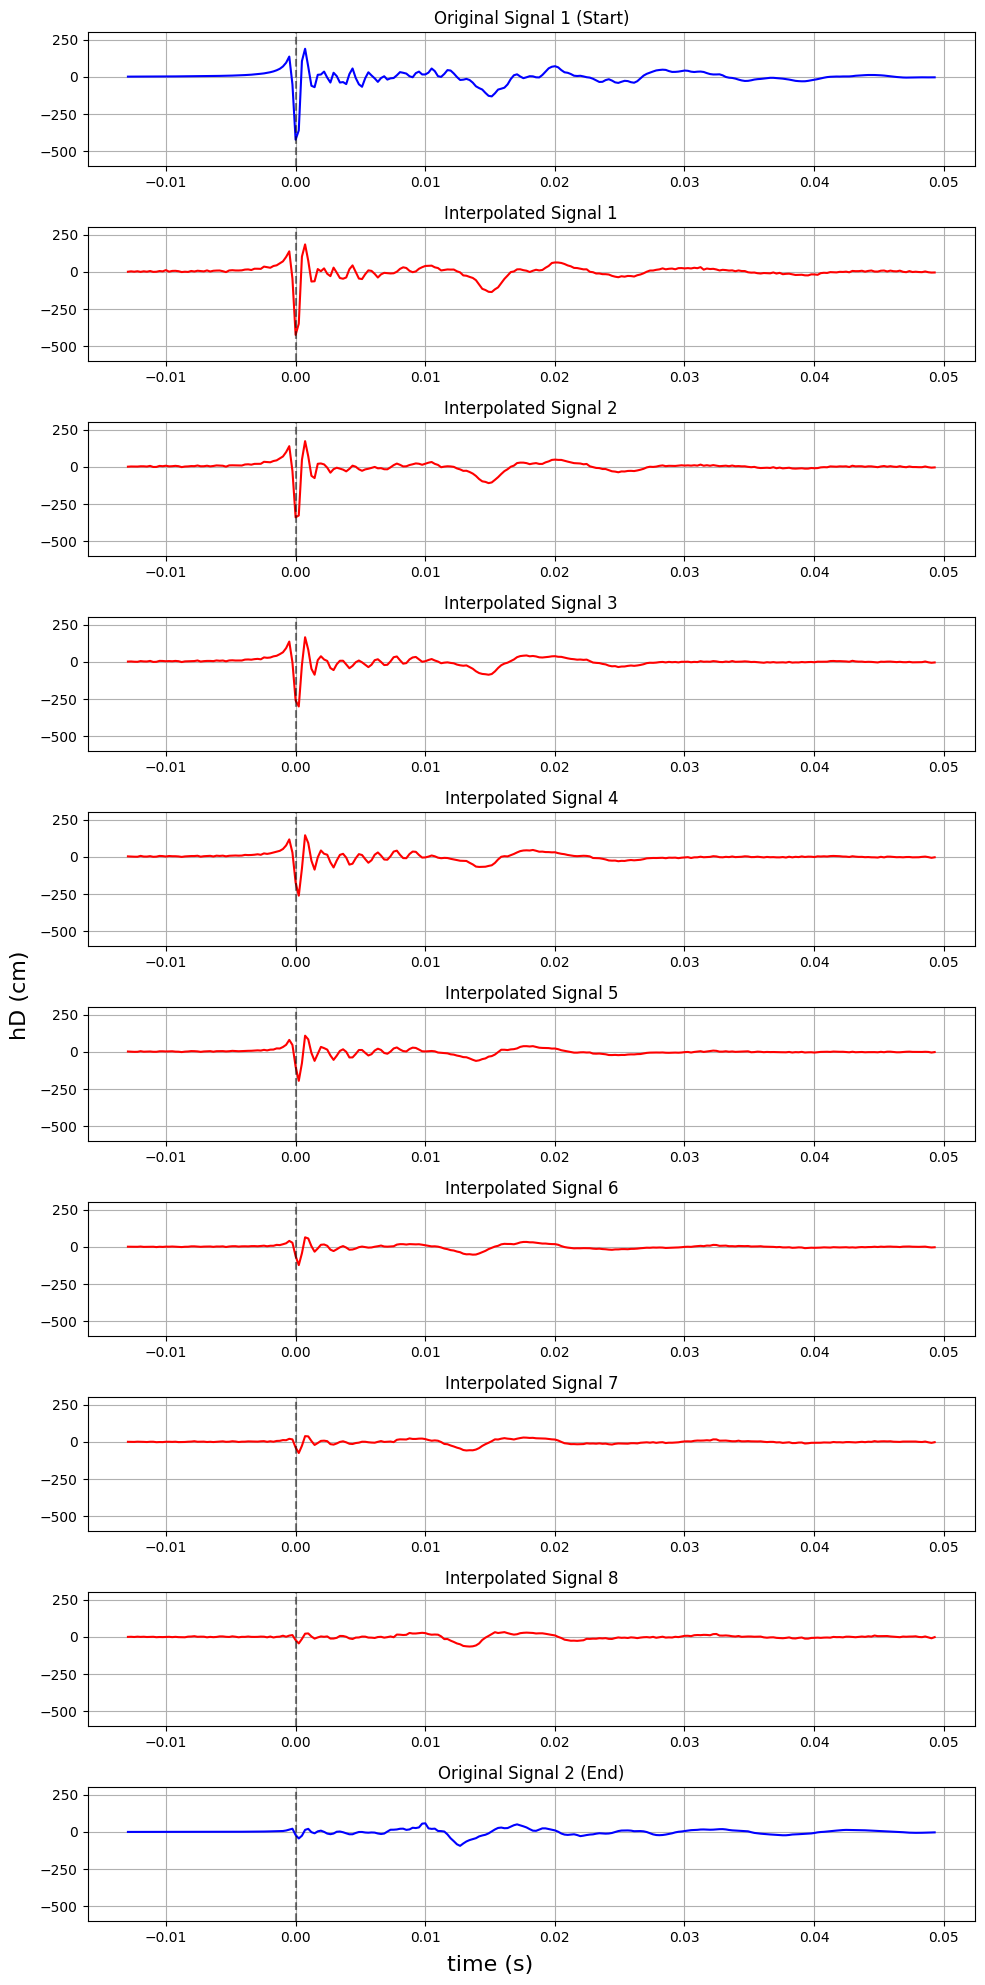

Training:  41%|████      | 41/100 [00:33<00:56,  1.04it/s]

Epoch 41, Train Loss: 33.3441, Val Loss: 39.7620


Training:  42%|████▏     | 42/100 [00:34<00:51,  1.14it/s]

Epoch 42, Train Loss: 33.3434, Val Loss: 39.5156


Training:  43%|████▎     | 43/100 [00:34<00:47,  1.20it/s]

Epoch 43, Train Loss: 33.1661, Val Loss: 39.6183


Training:  44%|████▍     | 44/100 [00:35<00:43,  1.27it/s]

Epoch 44, Train Loss: 33.1440, Val Loss: 38.9676


Training:  45%|████▌     | 45/100 [00:36<00:42,  1.31it/s]

Epoch 45, Train Loss: 32.4338, Val Loss: 38.2108


Training:  46%|████▌     | 46/100 [00:36<00:39,  1.36it/s]

Epoch 46, Train Loss: 32.2083, Val Loss: 38.1277


Training:  47%|████▋     | 47/100 [00:37<00:38,  1.38it/s]

Epoch 47, Train Loss: 32.6485, Val Loss: 37.9819


Training:  48%|████▊     | 48/100 [00:38<00:36,  1.41it/s]

Epoch 48, Train Loss: 32.4520, Val Loss: 38.9882


Training:  49%|████▉     | 49/100 [00:38<00:35,  1.43it/s]

Epoch 49, Train Loss: 32.0657, Val Loss: 36.6442


Training:  49%|████▉     | 49/100 [00:39<00:35,  1.43it/s]

Epoch 50, Train Loss: 31.9968, Val Loss: 36.6368


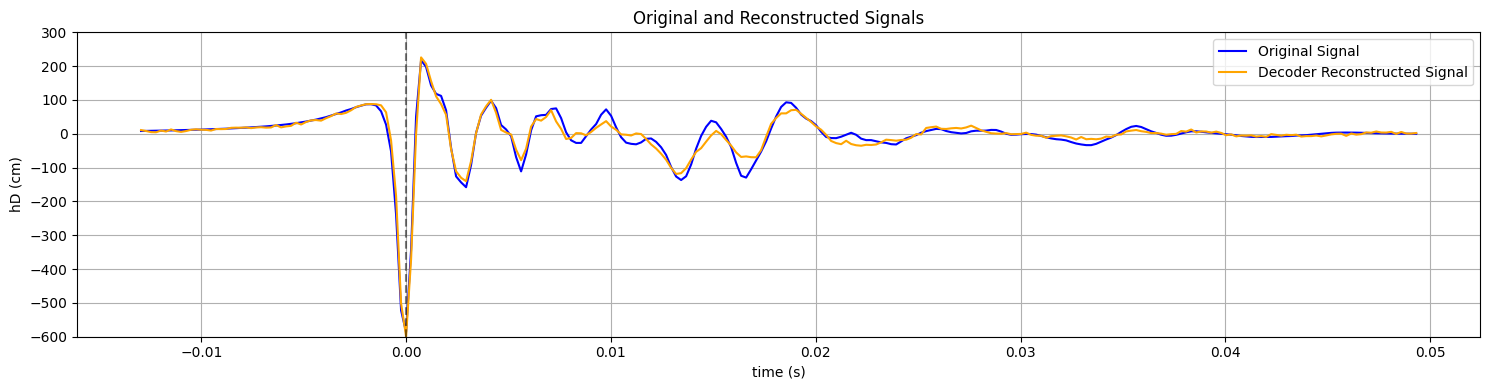

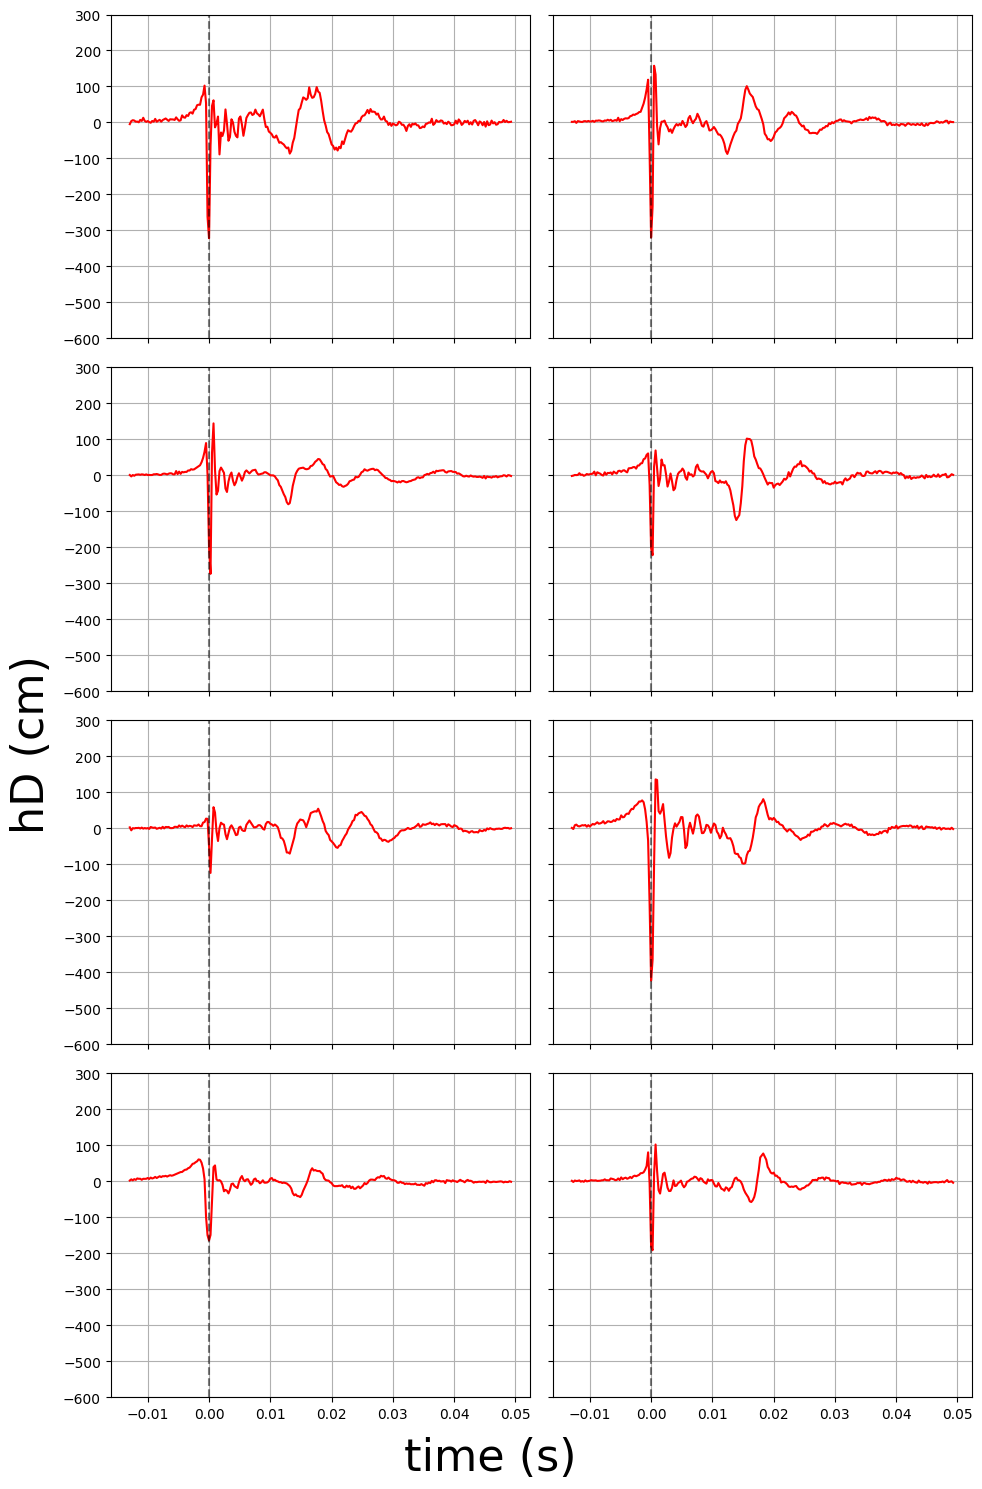

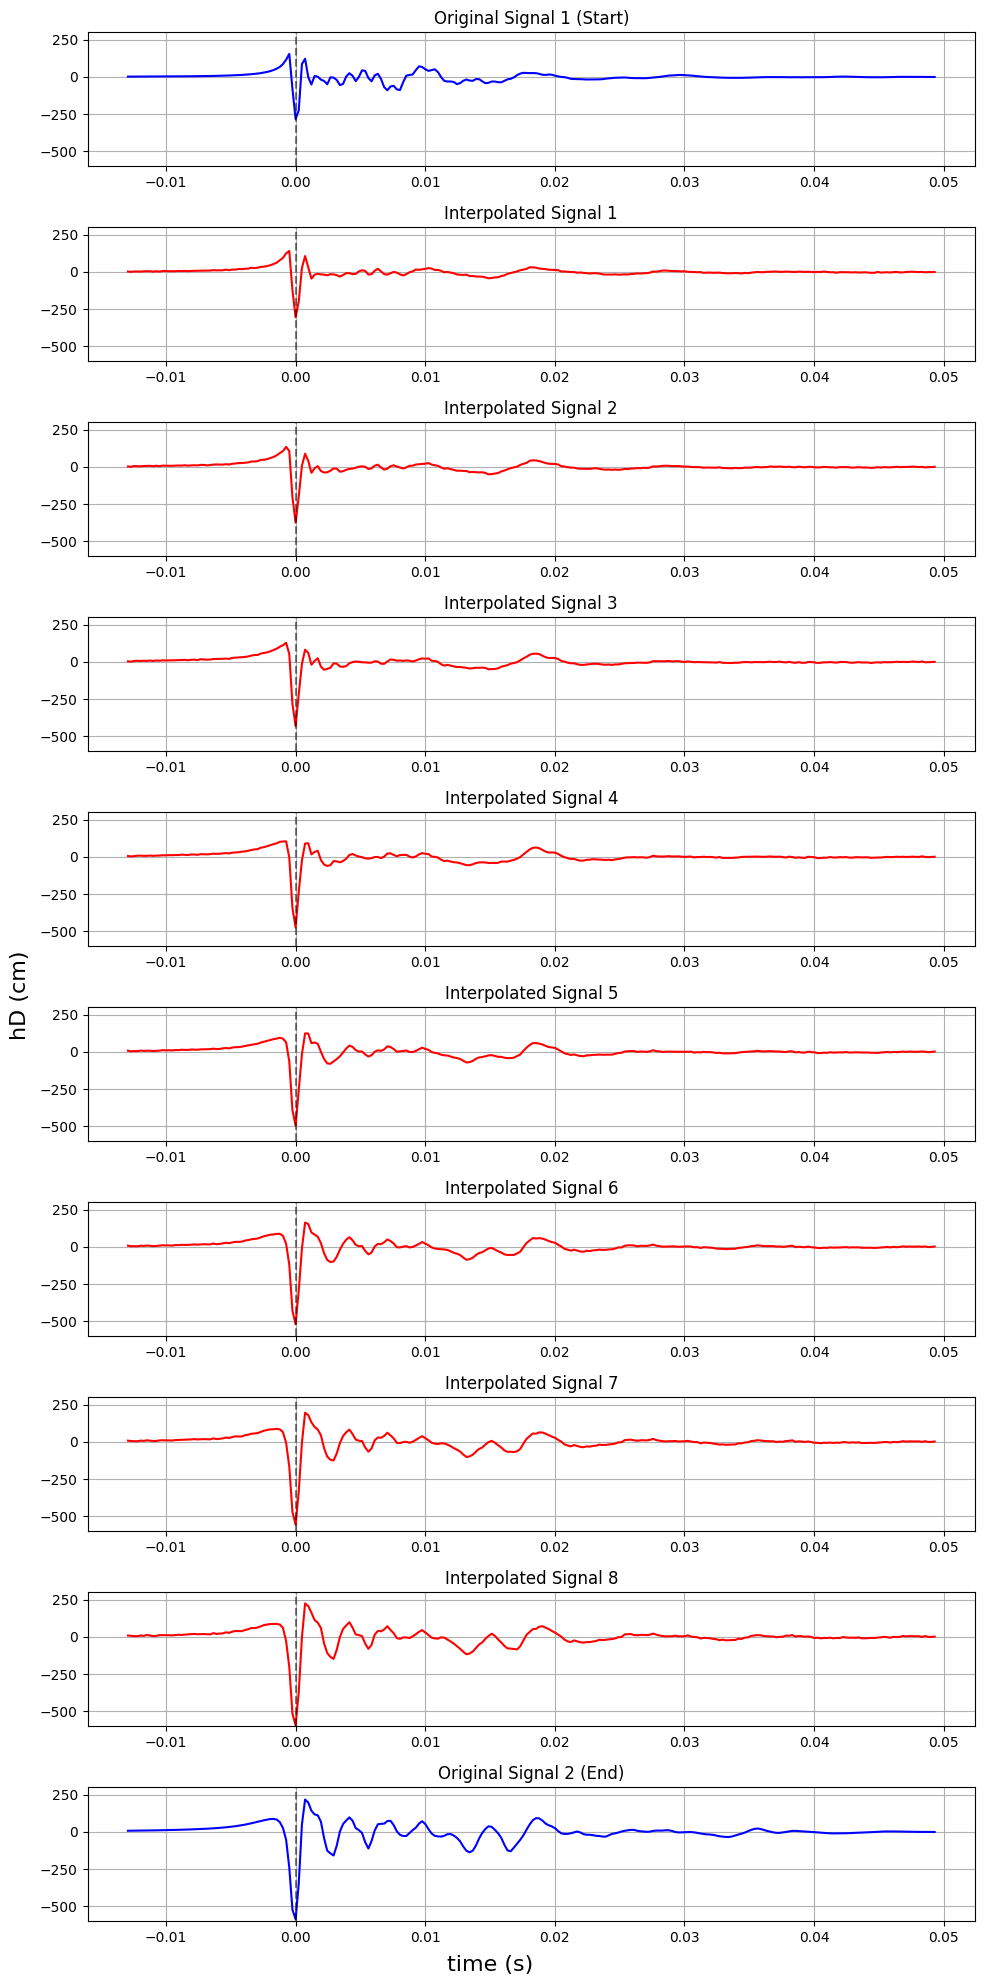

Training:  51%|█████     | 51/100 [00:41<00:46,  1.05it/s]

Epoch 51, Train Loss: 32.1027, Val Loss: 37.6111


Training:  52%|█████▏    | 52/100 [00:42<00:41,  1.16it/s]

Epoch 52, Train Loss: 31.6727, Val Loss: 36.5850


Training:  53%|█████▎    | 53/100 [00:42<00:37,  1.25it/s]

Epoch 53, Train Loss: 31.5994, Val Loss: 37.5013


Training:  54%|█████▍    | 54/100 [00:43<00:35,  1.30it/s]

Epoch 54, Train Loss: 31.5564, Val Loss: 37.9481


Training:  55%|█████▌    | 55/100 [00:44<00:33,  1.36it/s]

Epoch 55, Train Loss: 31.4220, Val Loss: 36.8491


Training:  56%|█████▌    | 56/100 [00:44<00:31,  1.38it/s]

Epoch 56, Train Loss: 31.1008, Val Loss: 37.2192


Training:  57%|█████▋    | 57/100 [00:45<00:30,  1.42it/s]

Epoch 57, Train Loss: 31.5490, Val Loss: 38.1402


Training:  58%|█████▊    | 58/100 [00:46<00:29,  1.43it/s]

Epoch 58, Train Loss: 31.3917, Val Loss: 37.4904


Training:  59%|█████▉    | 59/100 [00:46<00:28,  1.45it/s]

Epoch 59, Train Loss: 31.6852, Val Loss: 36.9771


Training:  59%|█████▉    | 59/100 [00:47<00:28,  1.45it/s]

Epoch 60, Train Loss: 30.6890, Val Loss: 35.7860


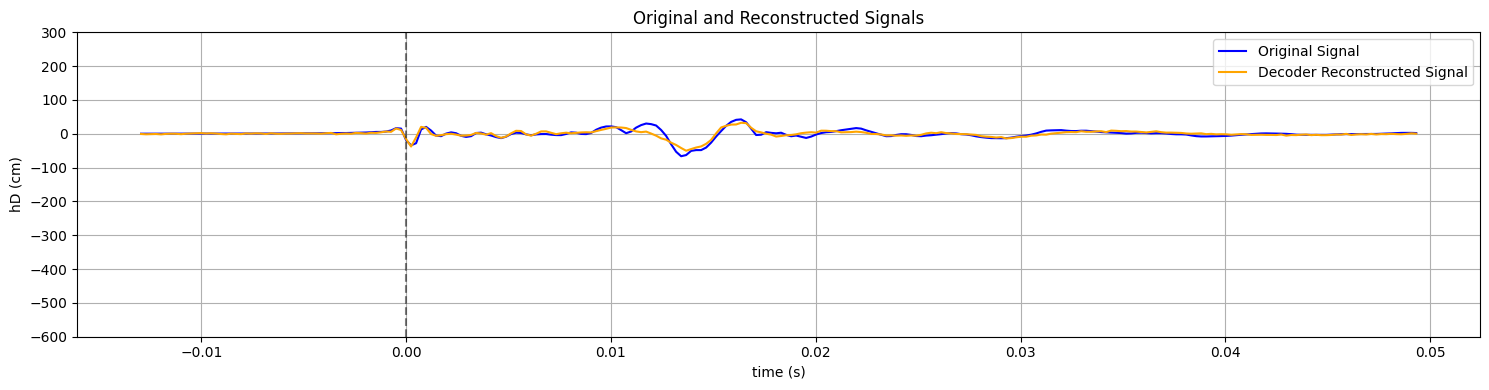

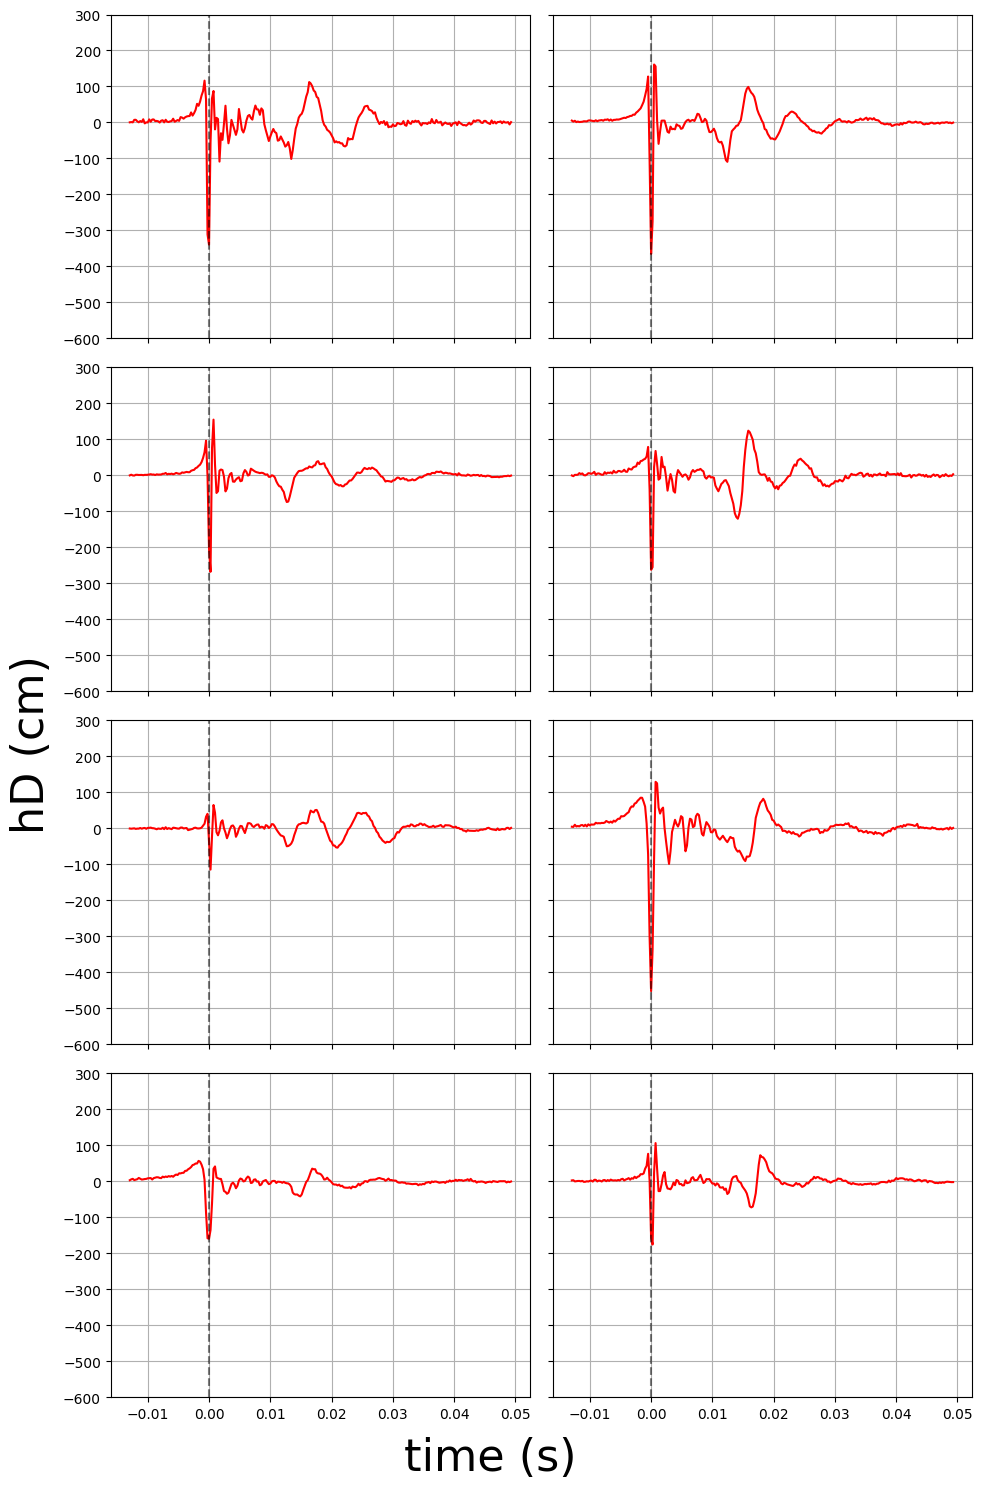

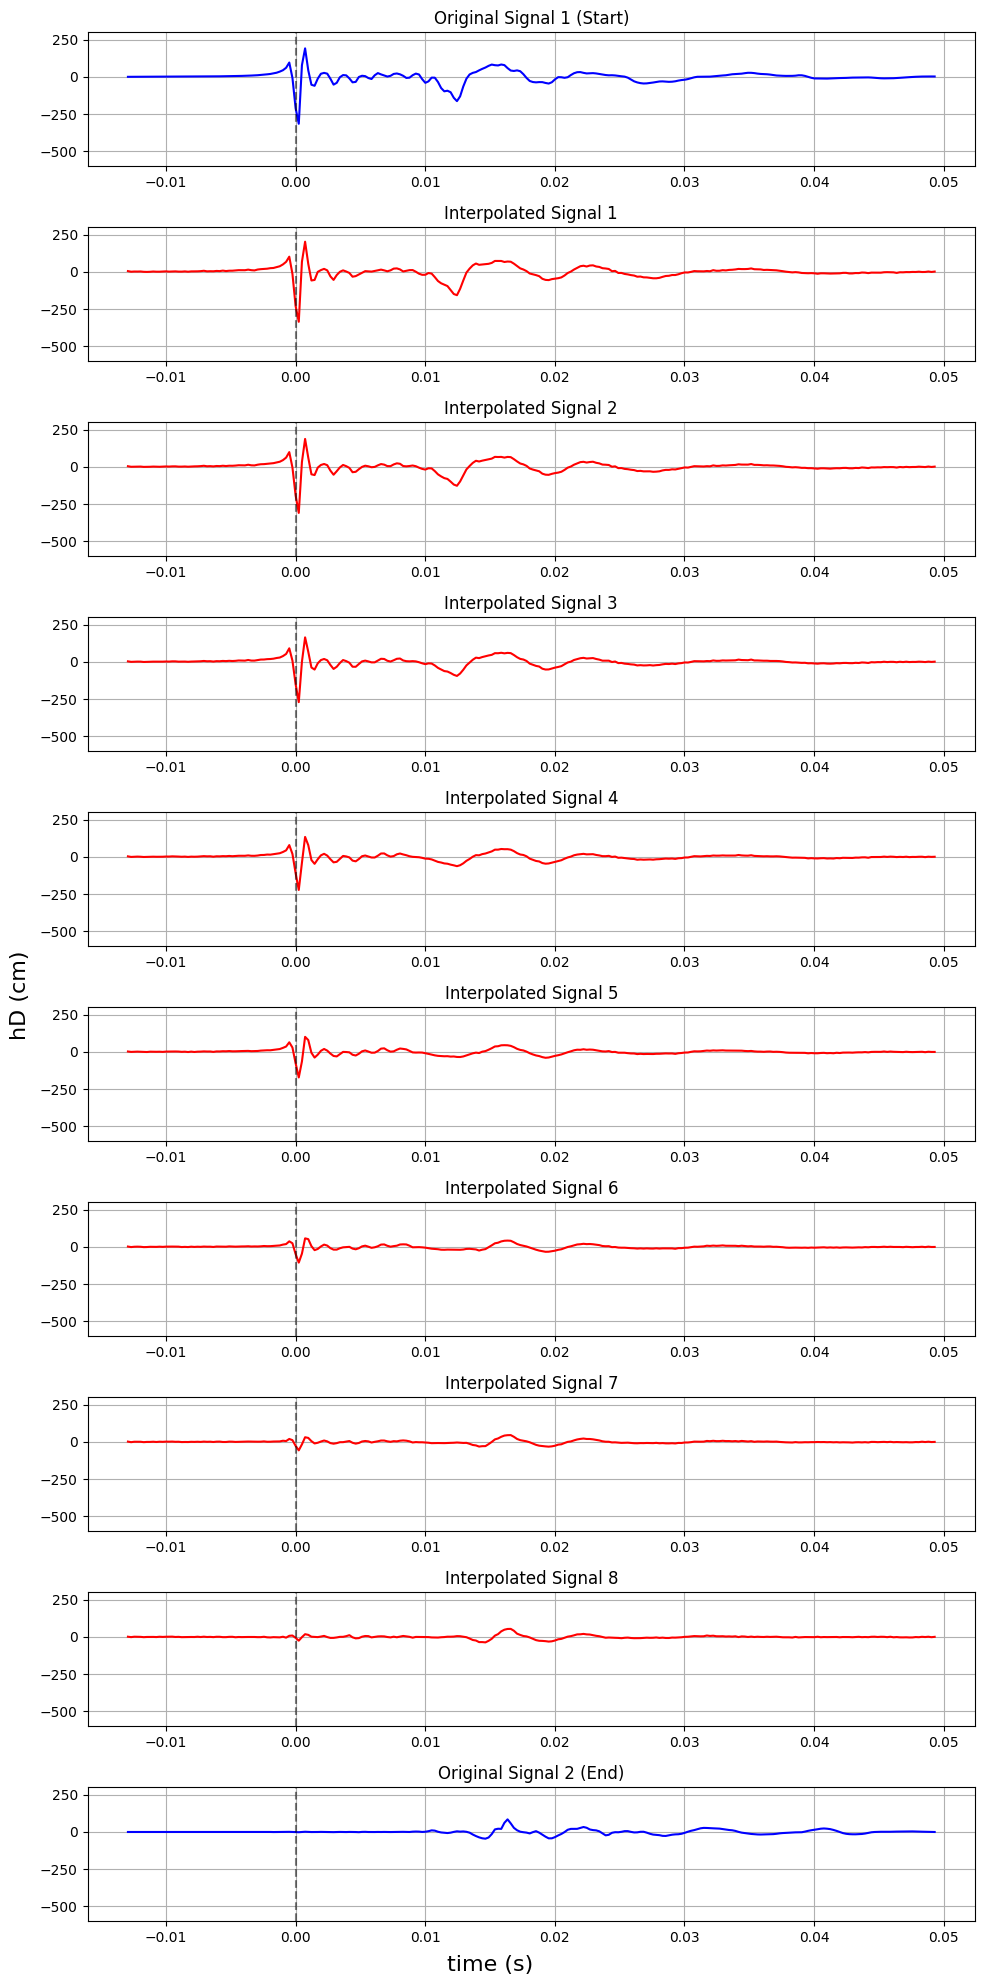

Training:  61%|██████    | 61/100 [00:49<00:37,  1.03it/s]

Epoch 61, Train Loss: 30.4545, Val Loss: 37.3939


Training:  62%|██████▏   | 62/100 [00:50<00:33,  1.14it/s]

Epoch 62, Train Loss: 30.2415, Val Loss: 35.5394


Training:  63%|██████▎   | 63/100 [00:50<00:30,  1.22it/s]

Epoch 63, Train Loss: 29.6633, Val Loss: 35.9841


Training:  64%|██████▍   | 64/100 [00:51<00:27,  1.29it/s]

Epoch 64, Train Loss: 30.0669, Val Loss: 36.7945


Training:  65%|██████▌   | 65/100 [00:52<00:26,  1.34it/s]

Epoch 65, Train Loss: 30.2280, Val Loss: 36.0218


Training:  66%|██████▌   | 66/100 [00:52<00:24,  1.39it/s]

Epoch 66, Train Loss: 30.0916, Val Loss: 36.4343


Training:  67%|██████▋   | 67/100 [00:53<00:24,  1.37it/s]

Epoch 67, Train Loss: 29.7597, Val Loss: 36.8108


Training:  68%|██████▊   | 68/100 [00:54<00:22,  1.40it/s]

Epoch 68, Train Loss: 29.7147, Val Loss: 35.6885


Training:  69%|██████▉   | 69/100 [00:55<00:21,  1.41it/s]

Epoch 69, Train Loss: 29.3075, Val Loss: 35.2923


Training:  69%|██████▉   | 69/100 [00:55<00:21,  1.41it/s]

Epoch 70, Train Loss: 29.9207, Val Loss: 36.5047


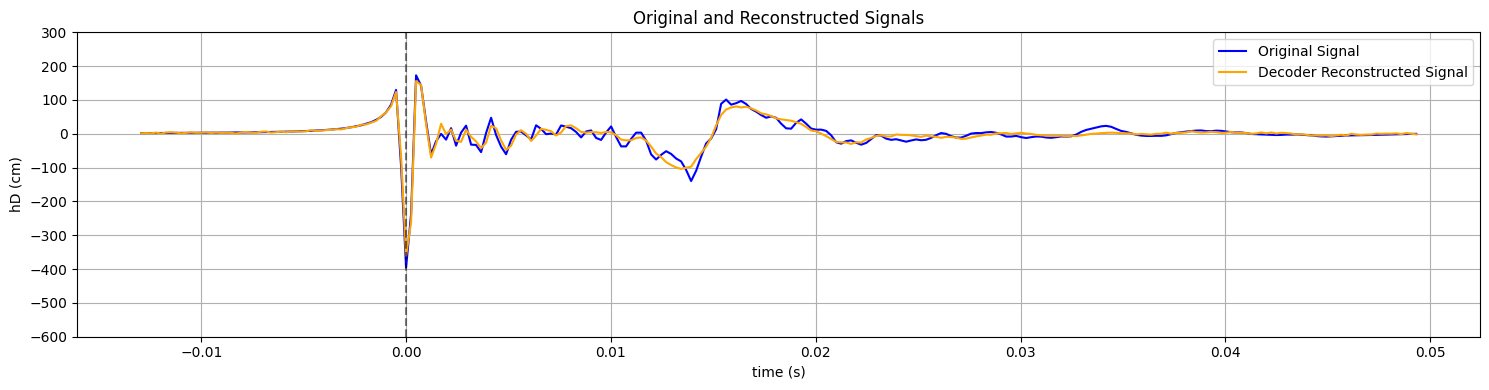

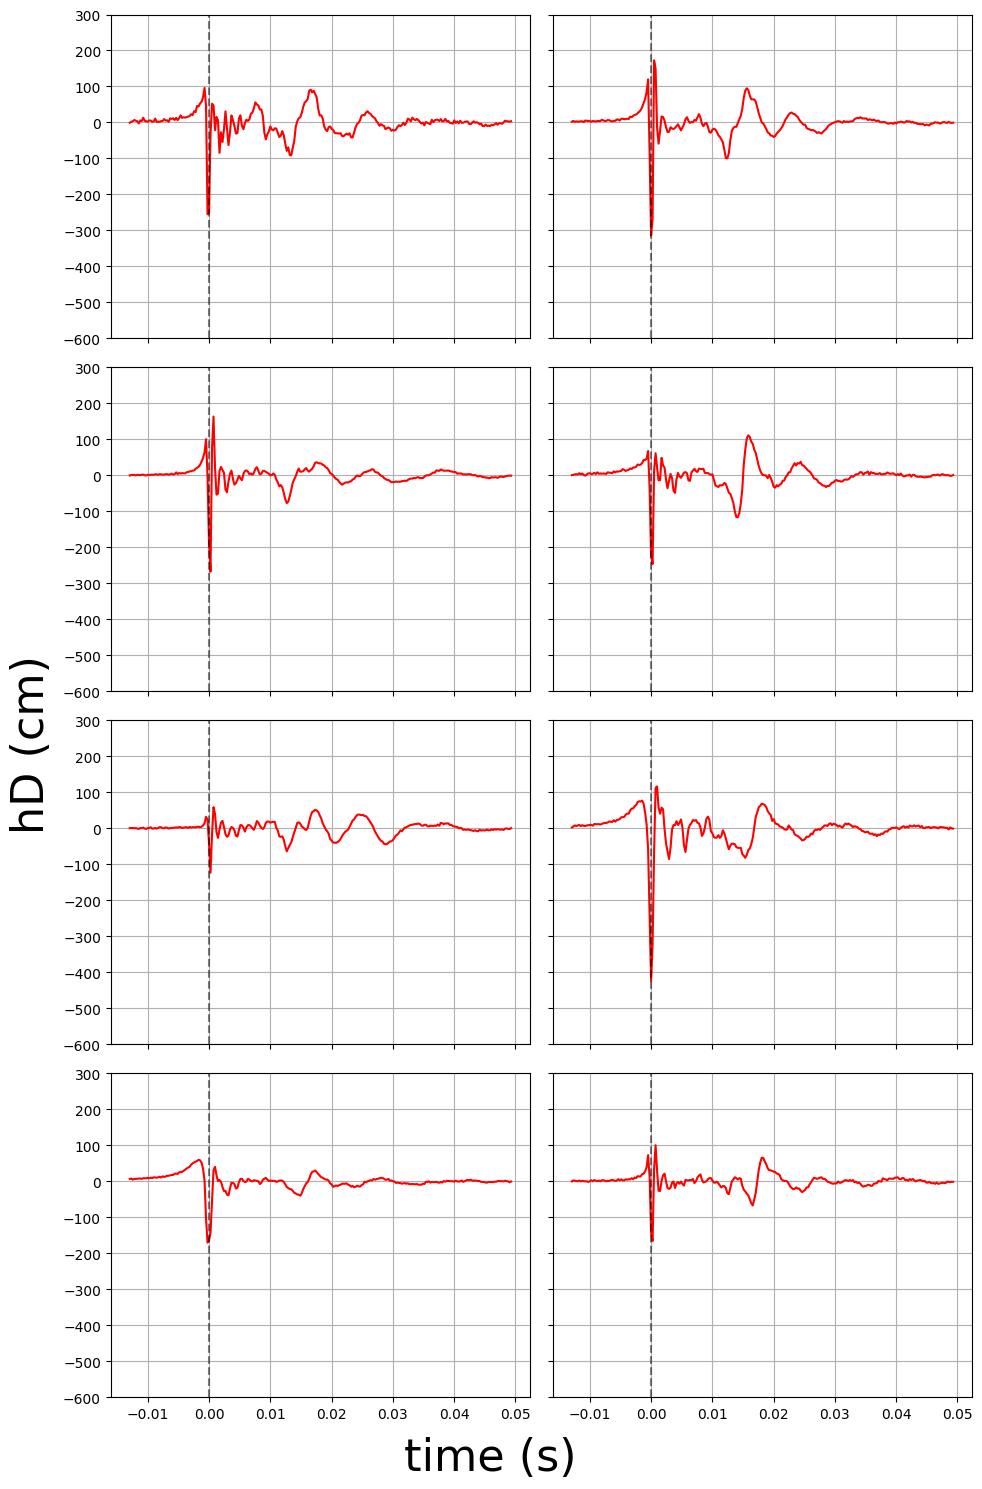

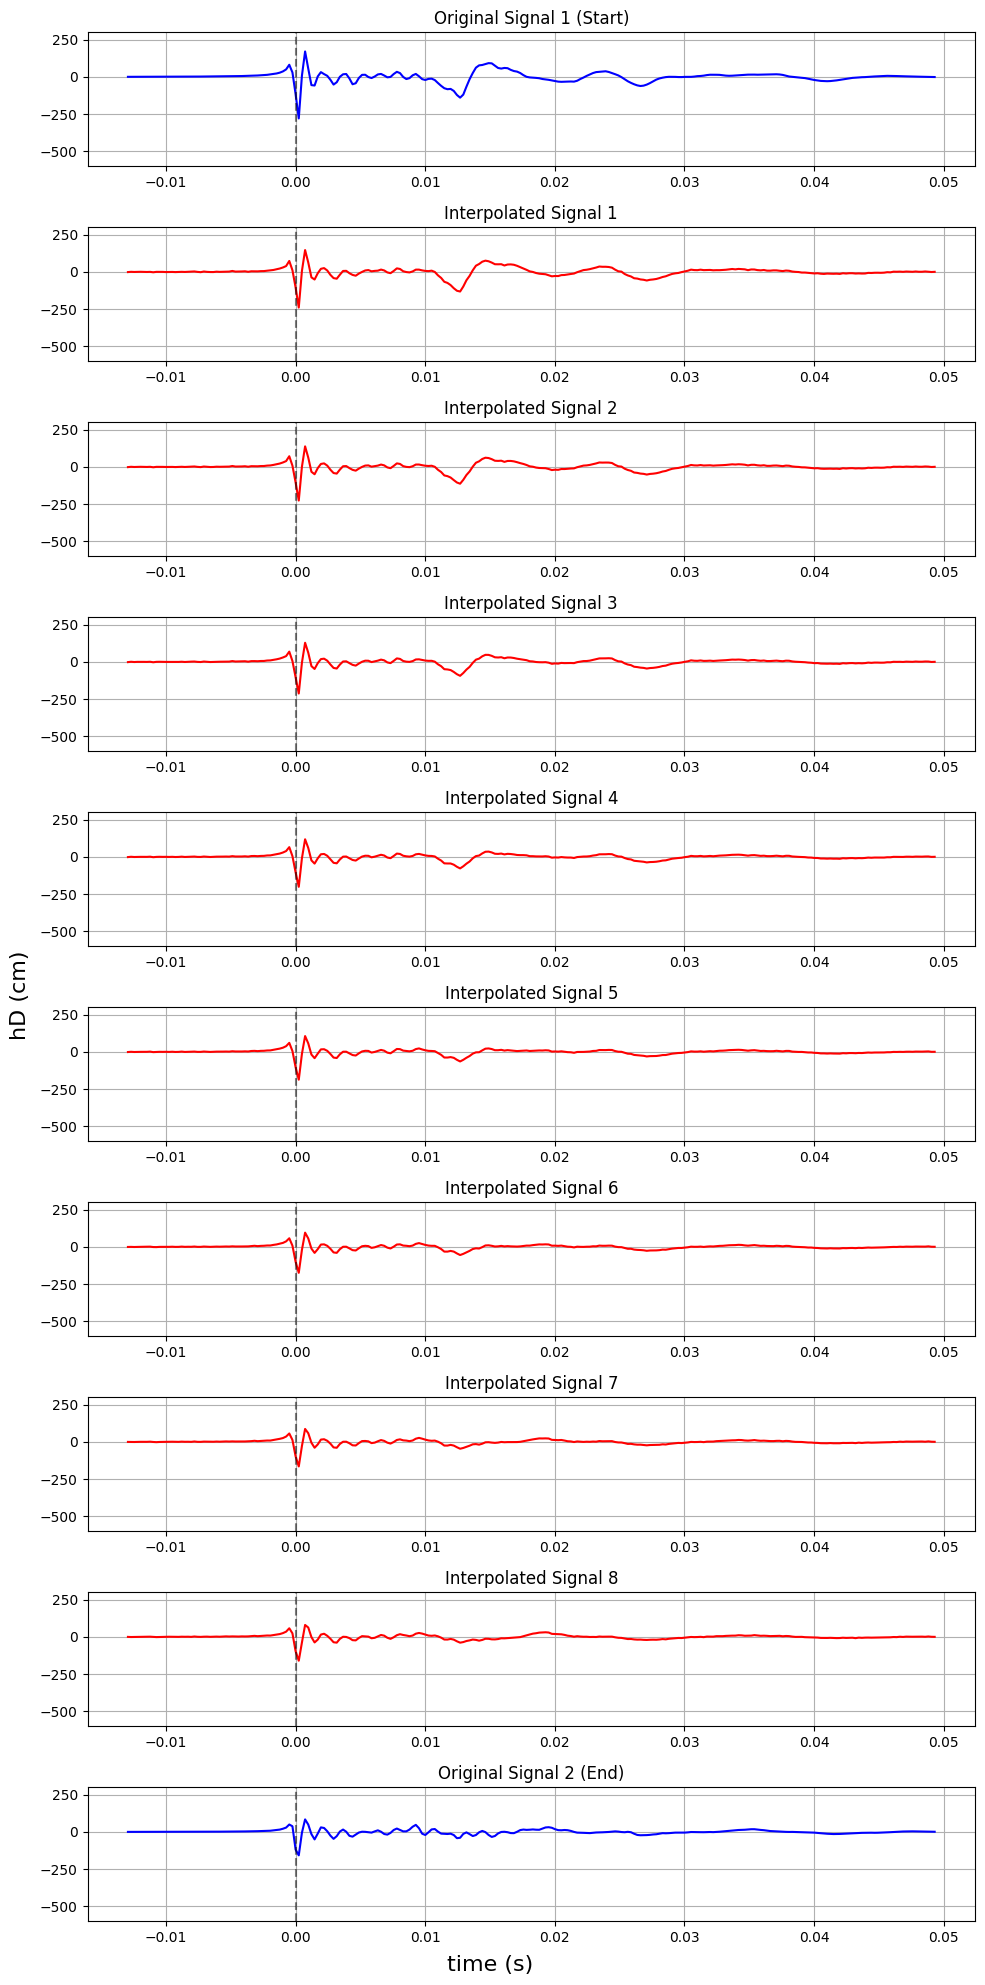

Training:  71%|███████   | 71/100 [00:57<00:27,  1.04it/s]

Epoch 71, Train Loss: 29.2808, Val Loss: 36.6157


Training:  72%|███████▏  | 72/100 [00:58<00:24,  1.12it/s]

Epoch 72, Train Loss: 29.8179, Val Loss: 36.3960


Training:  73%|███████▎  | 73/100 [00:59<00:22,  1.22it/s]

Epoch 73, Train Loss: 29.6741, Val Loss: 36.9456


Training:  74%|███████▍  | 74/100 [00:59<00:20,  1.29it/s]

Epoch 74, Train Loss: 29.3030, Val Loss: 35.8691


Training:  75%|███████▌  | 75/100 [01:00<00:18,  1.35it/s]

Epoch 75, Train Loss: 29.7456, Val Loss: 36.8789


Training:  76%|███████▌  | 76/100 [01:01<00:17,  1.38it/s]

Epoch 76, Train Loss: 29.0897, Val Loss: 35.3761


Training:  77%|███████▋  | 77/100 [01:01<00:16,  1.42it/s]

Epoch 77, Train Loss: 28.9358, Val Loss: 35.6150


Training:  78%|███████▊  | 78/100 [01:02<00:15,  1.44it/s]

Epoch 78, Train Loss: 28.8604, Val Loss: 35.2065


Training:  79%|███████▉  | 79/100 [01:03<00:14,  1.45it/s]

Epoch 79, Train Loss: 28.8434, Val Loss: 35.9601


Training:  79%|███████▉  | 79/100 [01:03<00:14,  1.45it/s]

Epoch 80, Train Loss: 28.9915, Val Loss: 35.8368


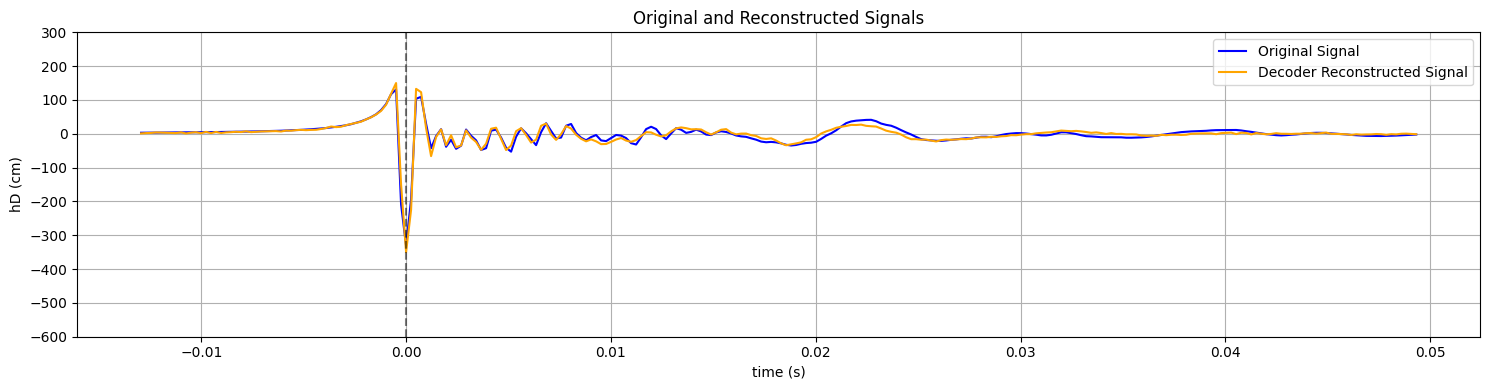

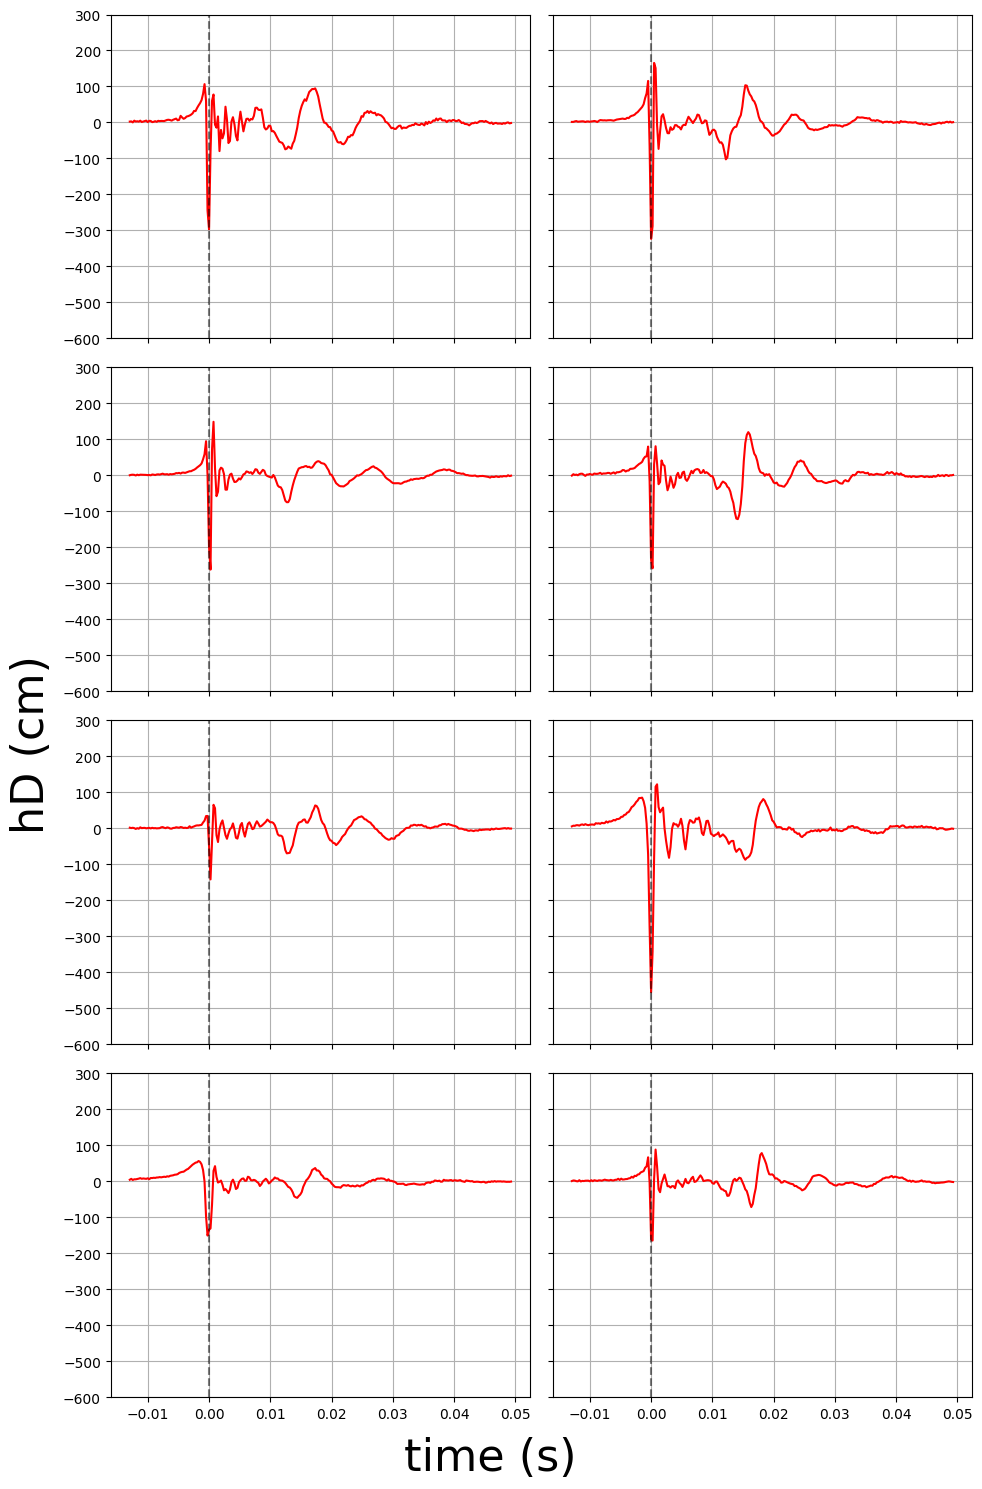

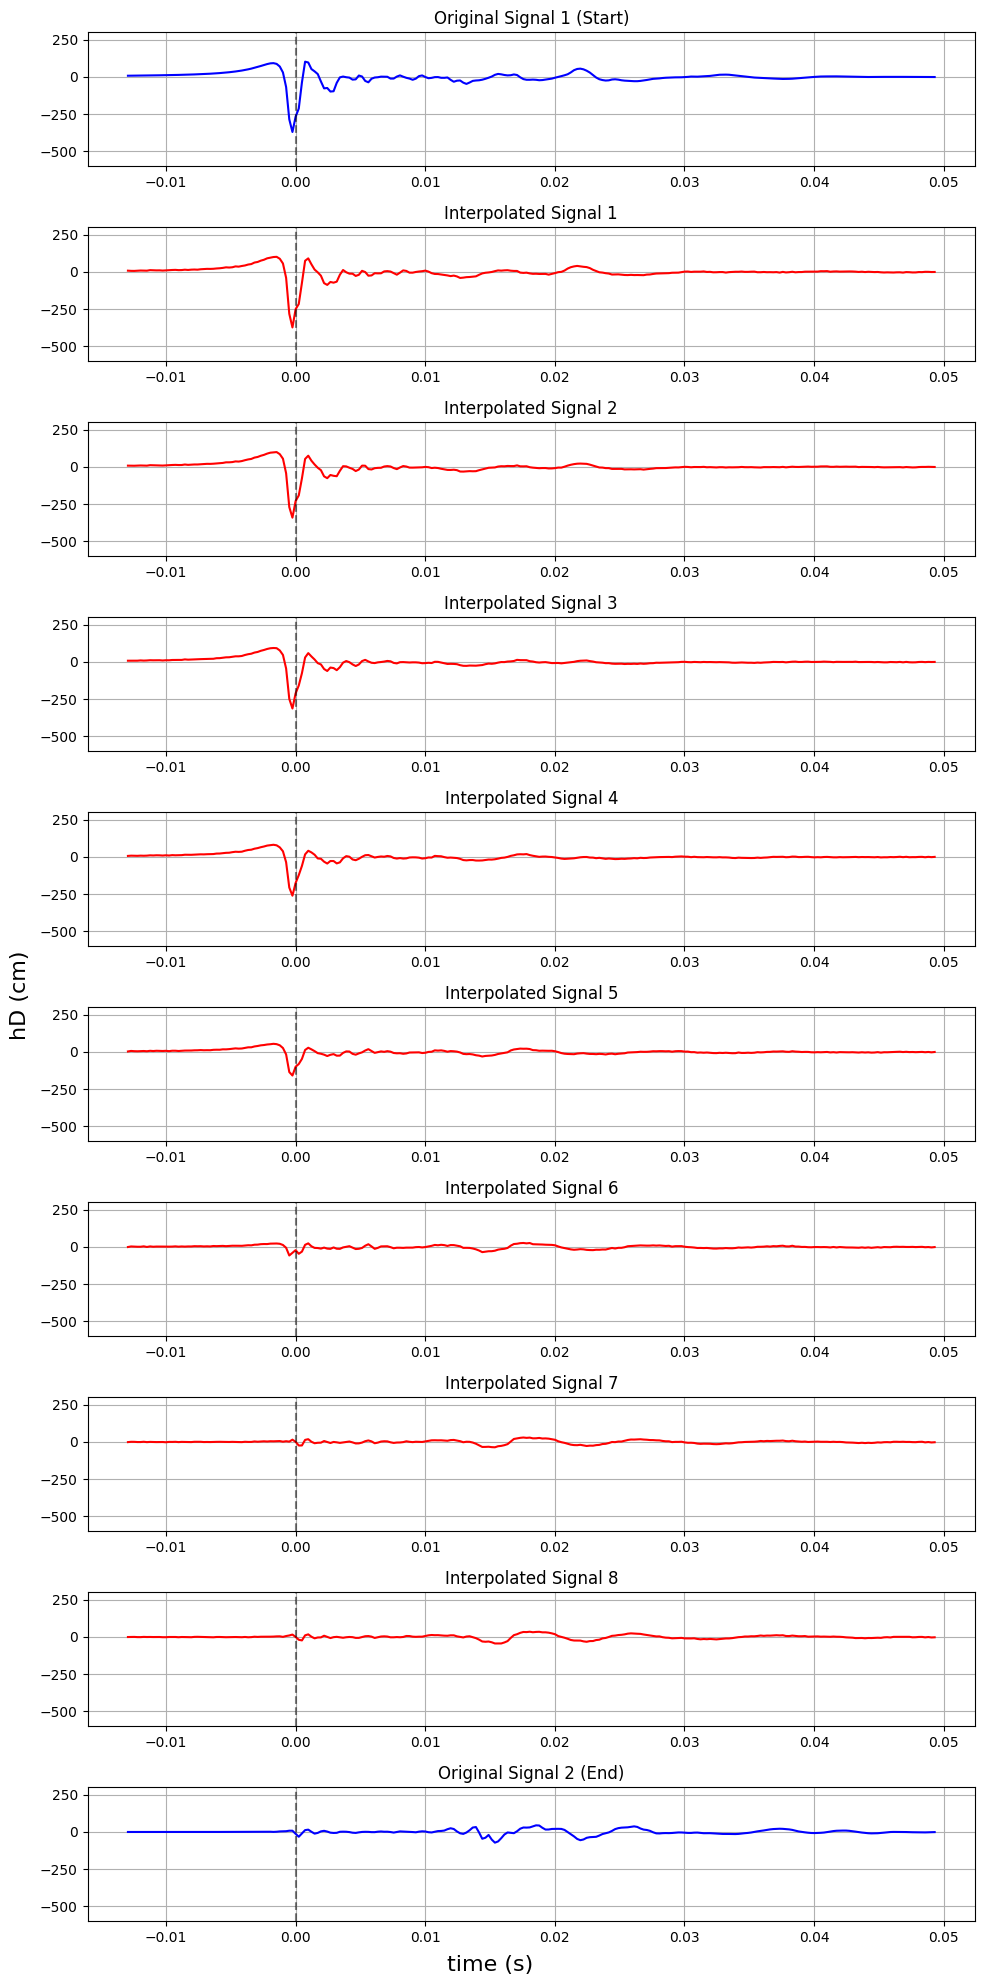

Training:  81%|████████  | 81/100 [01:05<00:18,  1.03it/s]

Epoch 81, Train Loss: 28.6081, Val Loss: 34.7609


Training:  82%|████████▏ | 82/100 [01:06<00:15,  1.13it/s]

Epoch 82, Train Loss: 28.7378, Val Loss: 35.4578


Training:  83%|████████▎ | 83/100 [01:07<00:14,  1.19it/s]

Epoch 83, Train Loss: 28.5737, Val Loss: 35.5144


Training:  84%|████████▍ | 84/100 [01:08<00:13,  1.20it/s]

Epoch 84, Train Loss: 28.5411, Val Loss: 36.0232


Training:  85%|████████▌ | 85/100 [01:08<00:12,  1.20it/s]

Epoch 85, Train Loss: 28.4296, Val Loss: 34.8689


Training:  86%|████████▌ | 86/100 [01:09<00:11,  1.22it/s]

Epoch 86, Train Loss: 28.3908, Val Loss: 34.9380


Training:  87%|████████▋ | 87/100 [01:10<00:10,  1.26it/s]

Epoch 87, Train Loss: 28.7491, Val Loss: 35.4959


Training:  88%|████████▊ | 88/100 [01:11<00:09,  1.29it/s]

Epoch 88, Train Loss: 28.4617, Val Loss: 34.8032


Training:  89%|████████▉ | 89/100 [01:11<00:08,  1.29it/s]

Epoch 89, Train Loss: 28.4979, Val Loss: 35.7211


Training:  89%|████████▉ | 89/100 [01:12<00:08,  1.29it/s]

Epoch 90, Train Loss: 28.5880, Val Loss: 35.2094


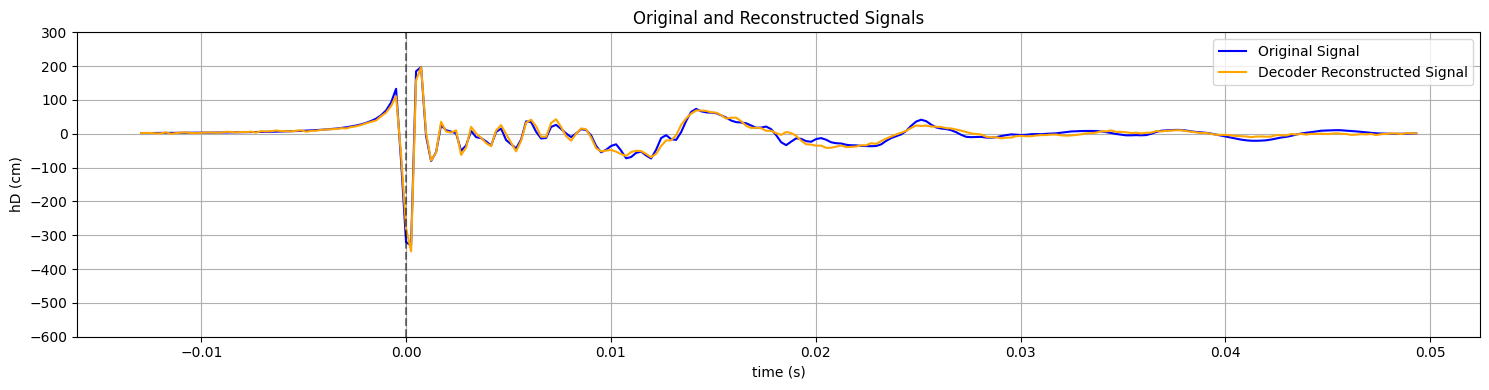

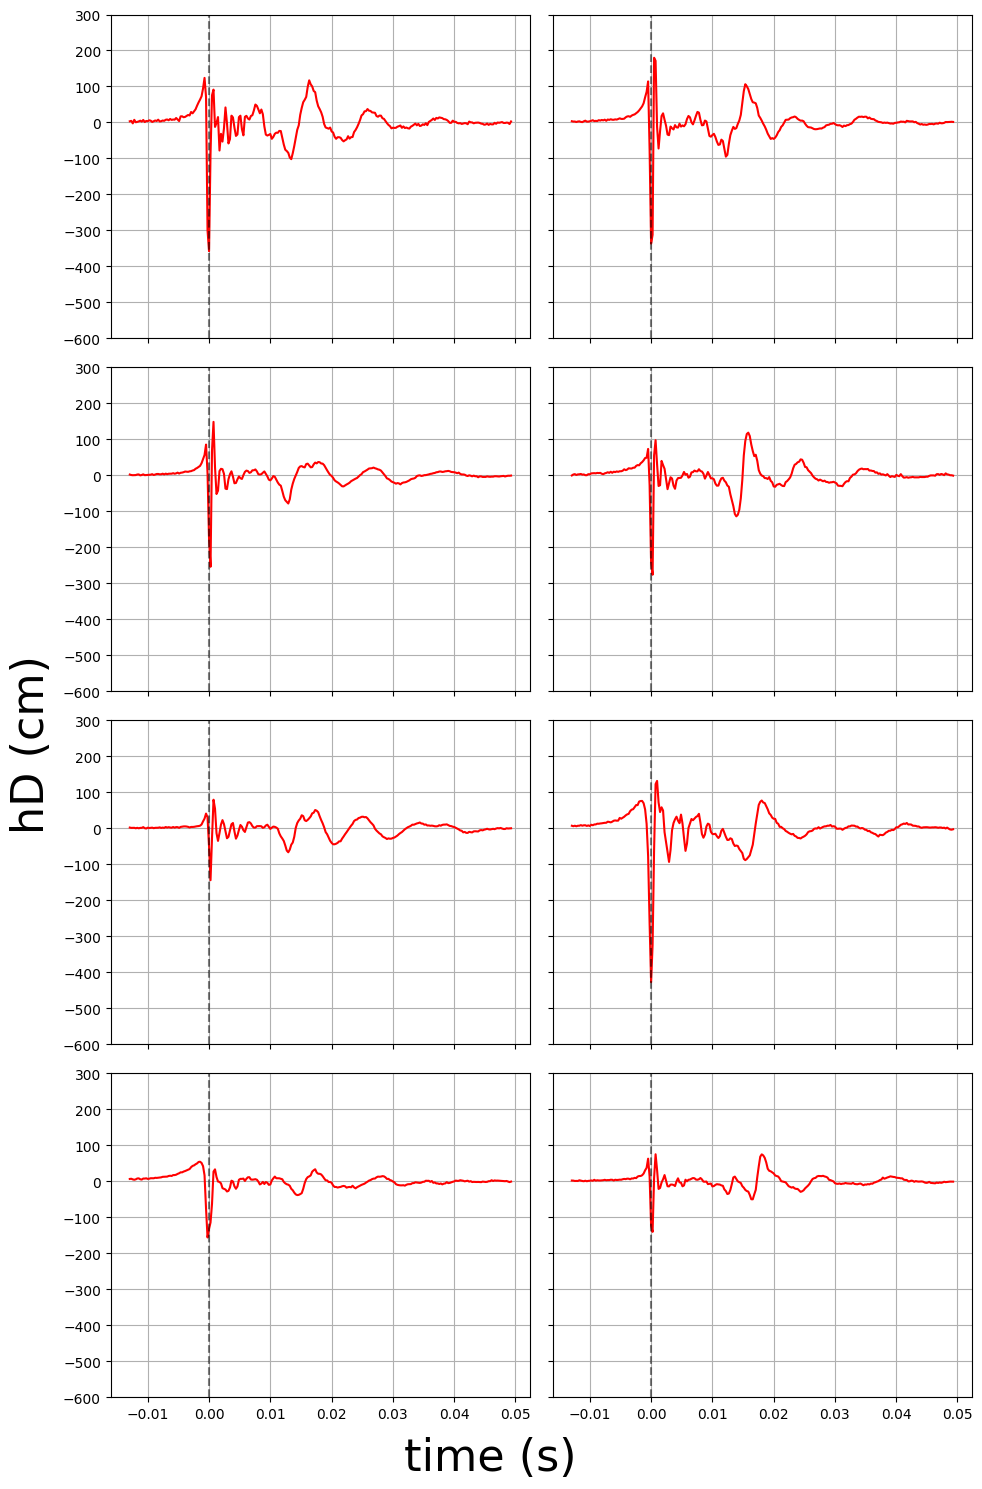

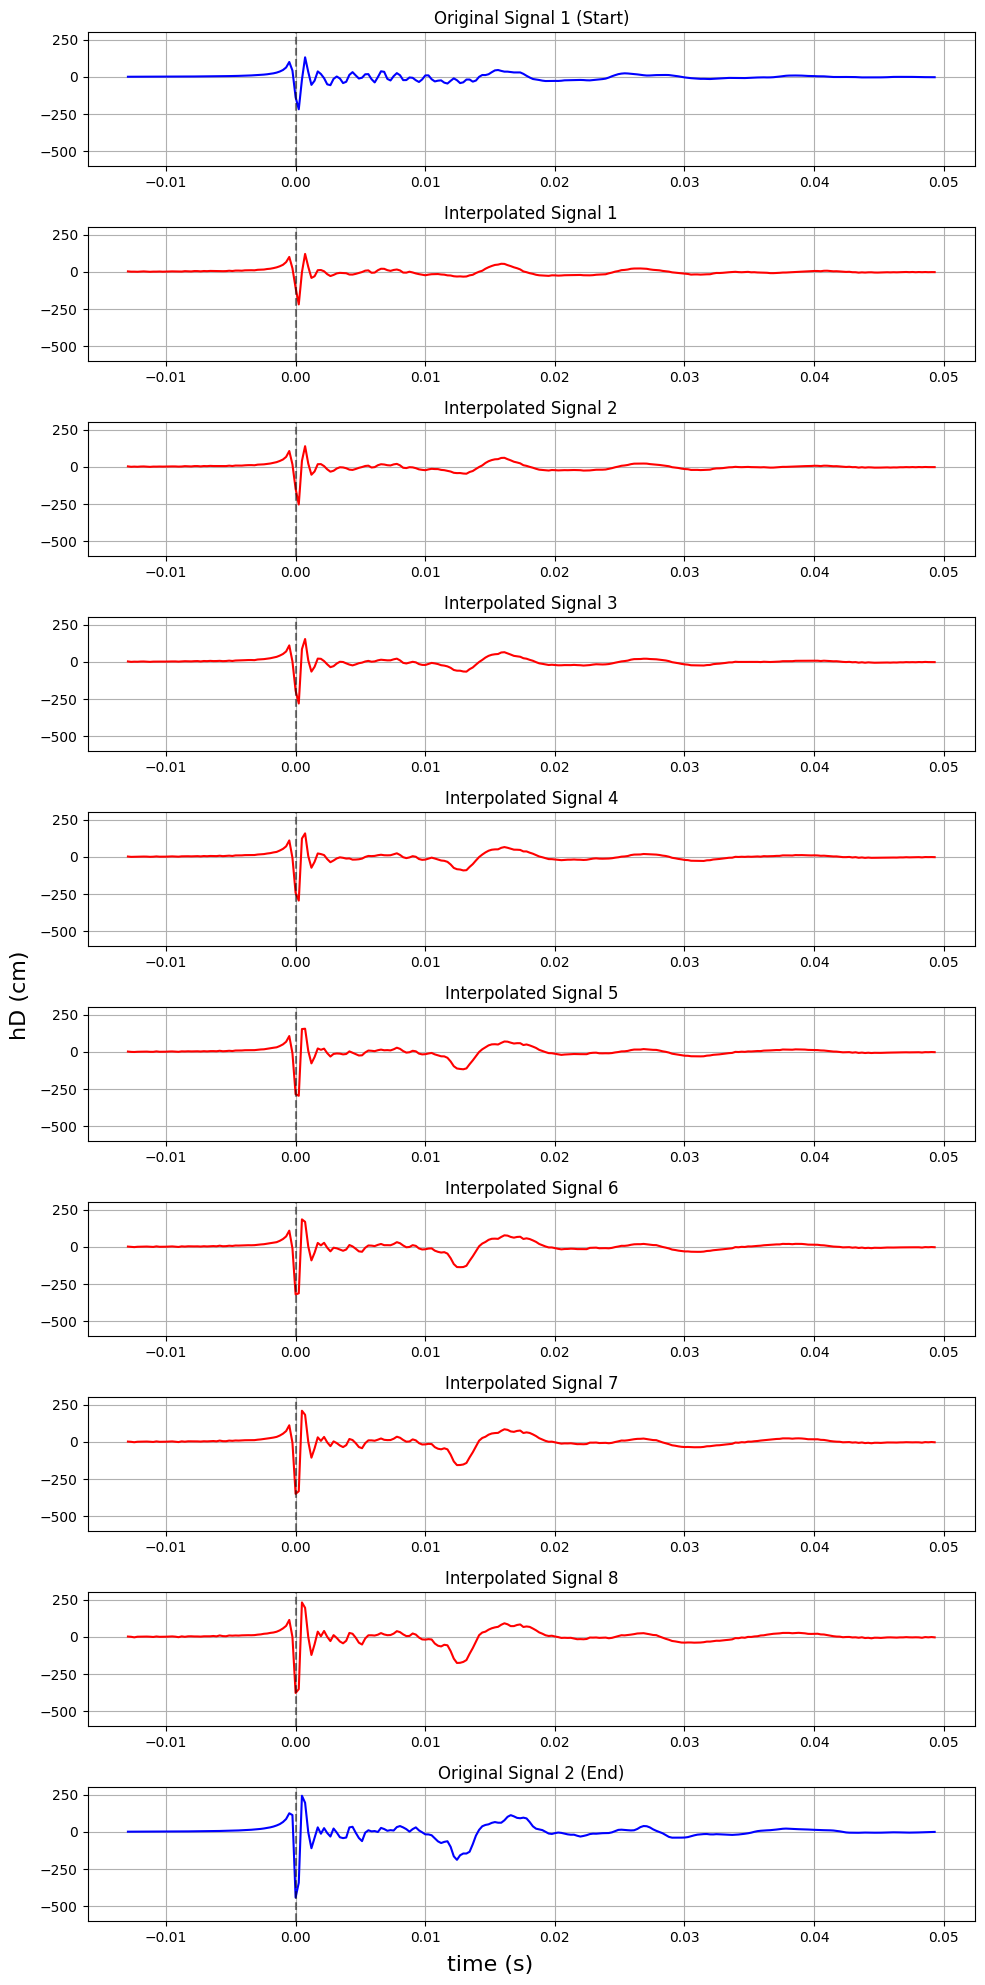

Training:  91%|█████████ | 91/100 [01:14<00:09,  1.01s/it]

Epoch 91, Train Loss: 28.3670, Val Loss: 34.8309


Training:  92%|█████████▏| 92/100 [01:15<00:07,  1.09it/s]

Epoch 92, Train Loss: 27.8301, Val Loss: 35.1618


Training:  93%|█████████▎| 93/100 [01:16<00:05,  1.18it/s]

Epoch 93, Train Loss: 28.1286, Val Loss: 35.0373


Training:  94%|█████████▍| 94/100 [01:16<00:04,  1.25it/s]

Epoch 94, Train Loss: 28.0979, Val Loss: 35.0501


Training:  95%|█████████▌| 95/100 [01:17<00:03,  1.29it/s]

Epoch 95, Train Loss: 27.6137, Val Loss: 35.4988


Training:  96%|█████████▌| 96/100 [01:18<00:02,  1.34it/s]

Epoch 96, Train Loss: 27.9451, Val Loss: 35.1767


Training:  97%|█████████▋| 97/100 [01:18<00:02,  1.39it/s]

Epoch 97, Train Loss: 27.9596, Val Loss: 34.9084


Training:  98%|█████████▊| 98/100 [01:19<00:01,  1.40it/s]

Epoch 98, Train Loss: 27.9272, Val Loss: 35.3127


Training:  99%|█████████▉| 99/100 [01:20<00:00,  1.41it/s]

Epoch 99, Train Loss: 27.7706, Val Loss: 34.4320


Training:  99%|█████████▉| 99/100 [01:20<00:00,  1.41it/s]

Epoch 100, Train Loss: 27.5744, Val Loss: 35.3724


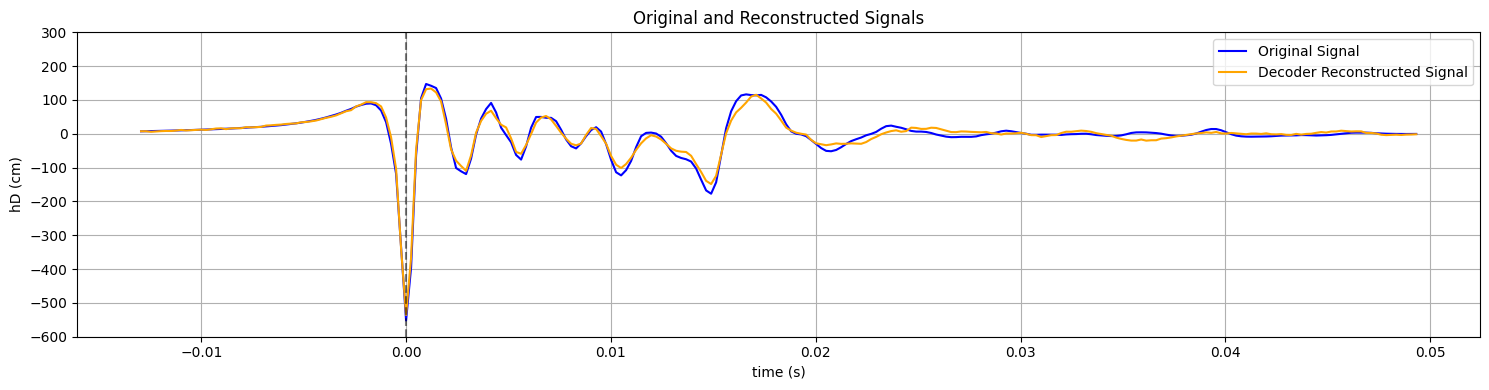

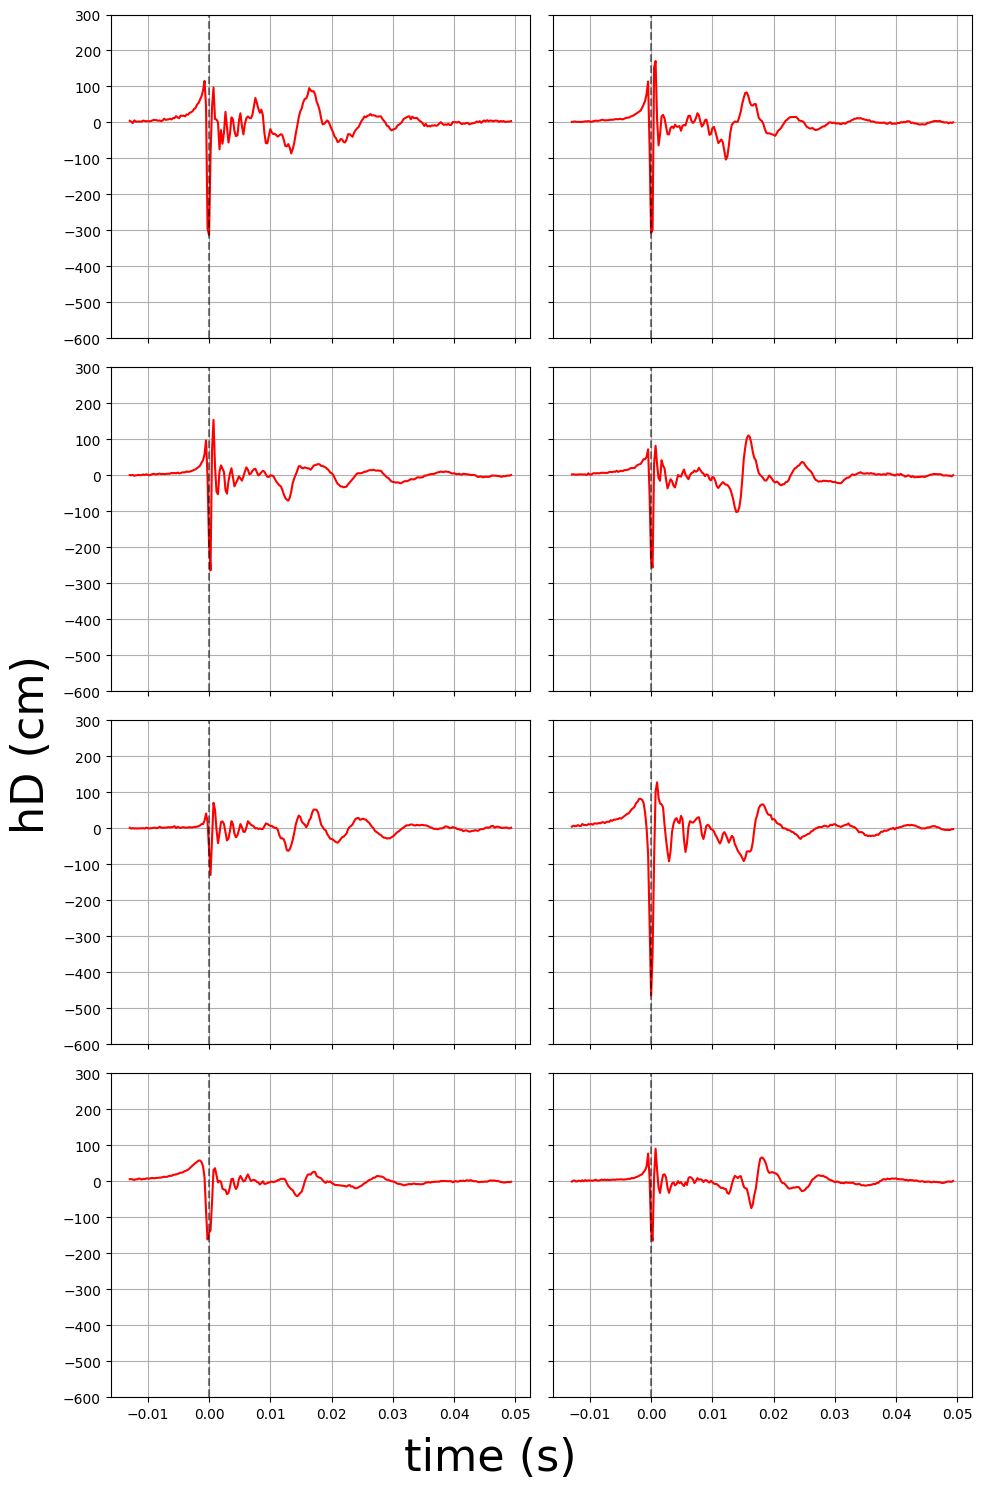

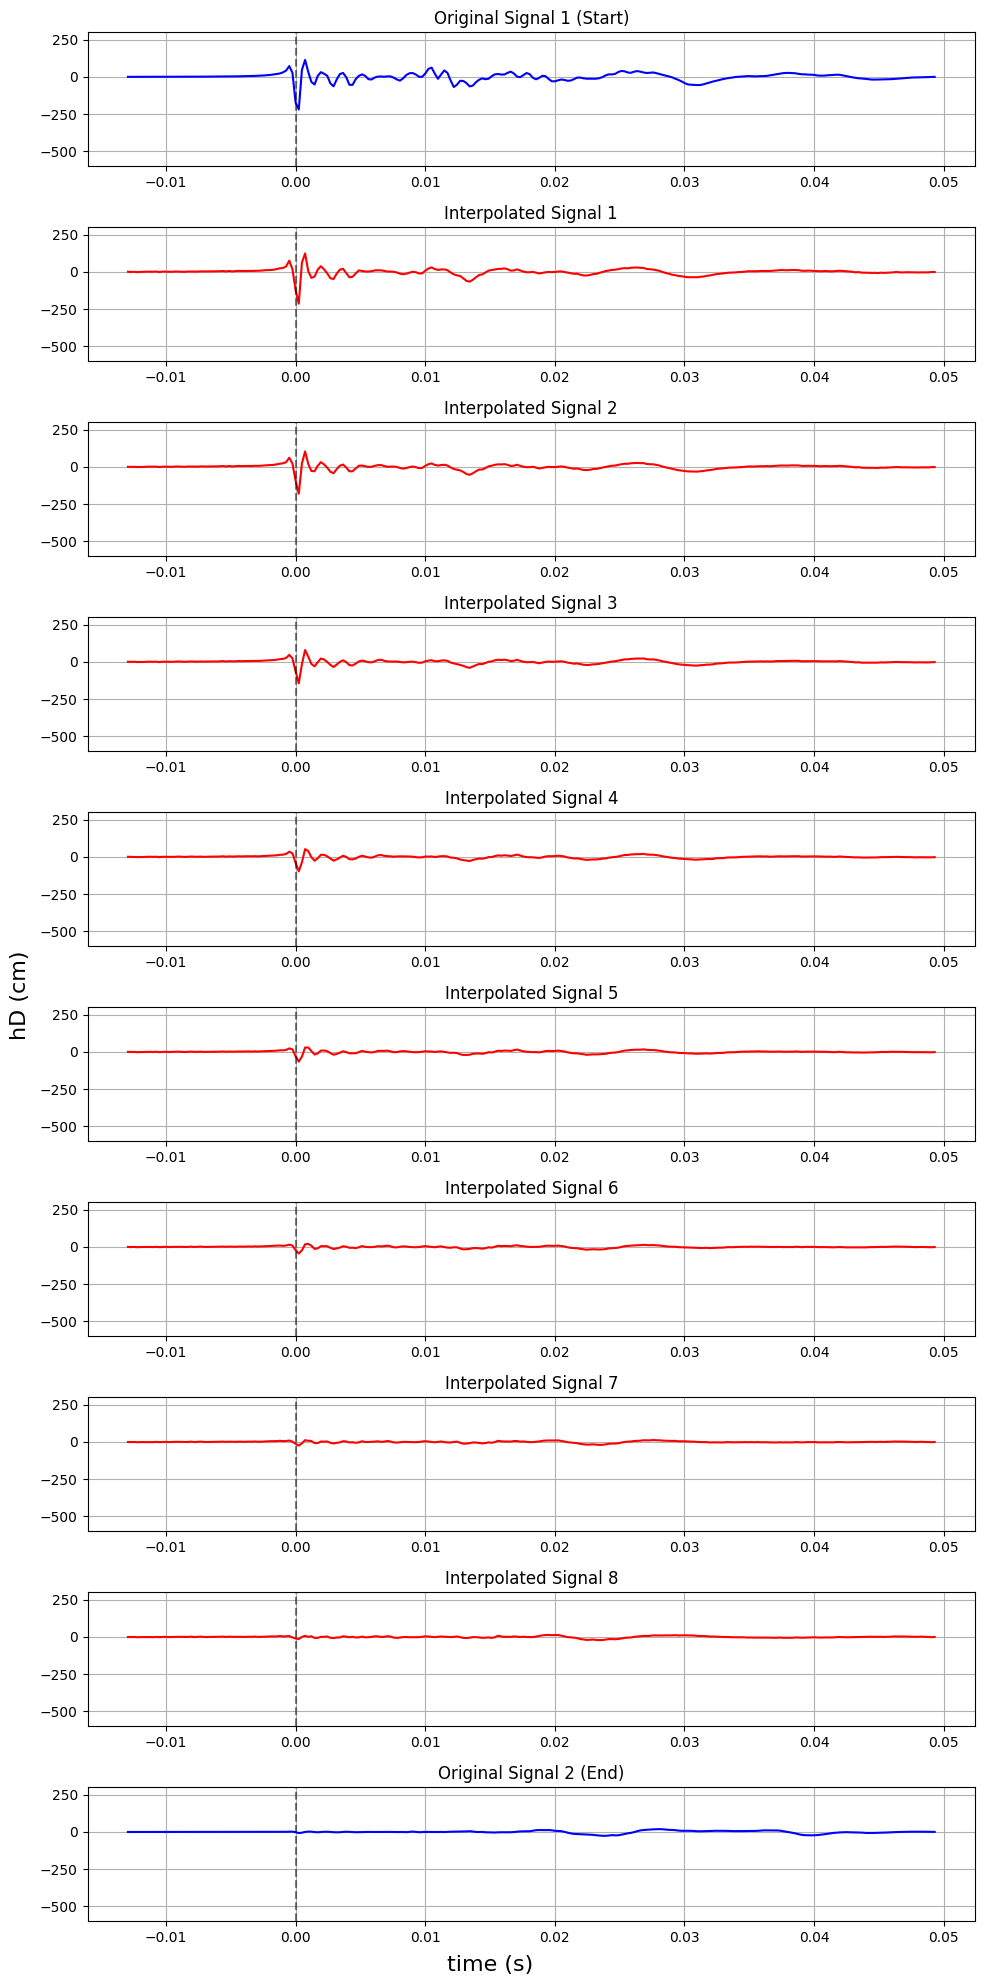

Training: 100%|██████████| 100/100 [01:22<00:00,  1.22it/s]

Training finished!


VAE(
  (encoder): Encoder(
    (FC_input): Linear(in_features=256, out_features=512, bias=True)
    (FC_input2): Linear(in_features=512, out_features=512, bias=True)
    (FC_mean): Linear(in_features=512, out_features=8, bias=True)
    (FC_var): Linear(in_features=512, out_features=8, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (FC_hidden): Linear(in_features=8, out_features=512, bias=True)
    (FC_hidden2): Linear(in_features=512, out_features=512, bias=True)
    (FC_output): Linear(in_features=512, out_features=256, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [37]:
print("Start training VAE...")
avg_total_losses = []
avg_reproduction_losses = []
avg_kld_losses = []

avg_total_losses_validation = []
avg_reproduction_losses_validation = []
avg_kld_losses_validation = []

noise = torch.randn(batch_size, latent_dim).to(DEVICE)

# validation data for validation
validation_data = []
for data in validation_dataloader:
    validation_data.append(data.to(DEVICE))
validation_data = torch.cat(validation_data, dim=0)

for epoch in tqdm(range(epochs), desc="Training"):
    overall_total_loss = 0
    overall_reproduction_loss = 0
    overall_kld_loss = 0

    overall_total_loss_validation = 0
    overall_reproduction_loss_validation = 0
    overall_kld_loss_validation = 0

    total_samples = 0

    for batch_idx, x in enumerate(train_dataloader, 0):
        model.train()
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        total_loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var)
        
        overall_total_loss += total_loss.item()
        overall_reproduction_loss += reproduction_loss.item()
        overall_kld_loss += KLD.item()
        total_samples += x.size(0)

        total_loss.backward()
        optimizer.step()

        # validation losses
        model.eval()
        with torch.no_grad():
            x_validation = validation_data
            x_validation = x_validation.view(x_validation.size(0), -1).to(DEVICE)
            x_hat_validation, mean_validation, log_var_validation = model(x_validation)
            total_loss_validation, reproduction_loss_validation, kld_loss_validation = loss_function(x_validation, x_hat_validation, mean_validation, log_var_validation)

    # summarise training losses
    avg_total_loss = overall_total_loss / total_samples
    avg_reproduction_loss = overall_reproduction_loss / total_samples
    avg_kld_loss = overall_kld_loss / total_samples

    avg_total_losses.append(avg_total_loss)
    avg_reproduction_losses.append(avg_reproduction_loss)
    avg_kld_losses.append(avg_kld_loss)

    # summarise validation losses
    avg_total_loss_validation = total_loss_validation.item() / x_validation.size(0)
    avg_reproduction_loss_validation = reproduction_loss_validation.item() / x_validation.size(0)
    avg_kld_loss_validation = kld_loss_validation.item() / x_validation.size(0)

    avg_total_losses_validation.append(avg_total_loss_validation)
    avg_reproduction_losses_validation.append(avg_reproduction_loss_validation)
    avg_kld_losses_validation.append(avg_kld_loss_validation)

    tqdm.write(f'Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_total_loss_validation:.4f}')

    if (epoch + 1) % 10 == 0:
        x = x.cpu().detach()
        x_hat = x_hat.cpu().detach()
        plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)

        with torch.no_grad():
            generated_signals = model.decoder(noise).cpu().detach().numpy()
        
        plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

        idx1 = torch.randint(0, x.size(0), (1,)).item()
        idx2 = idx1

        while idx2 == idx1: # ensures we don't sample the same signal
            idx2 = torch.randint(0, x.size(0), (1,)).item()

        signal_1 = x[idx1].to(DEVICE)
        signal_2 = x[idx2].to(DEVICE)
        
        plot_latent_morphs(model, signal_1, signal_2, max_value=train_dataset.max_value, steps=8)

print("Training finished!")
model.eval()

### Training and Validation Loss

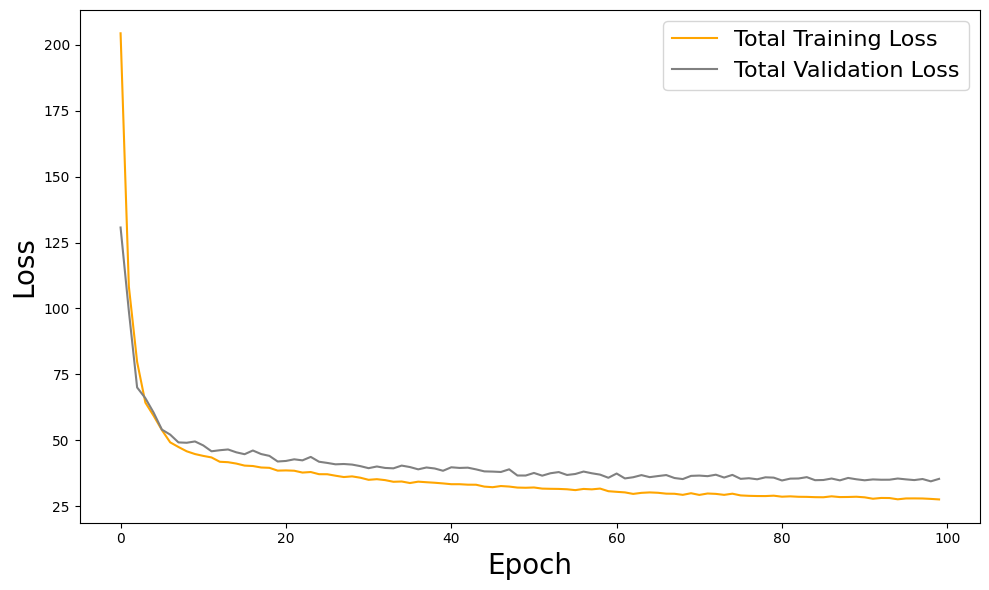

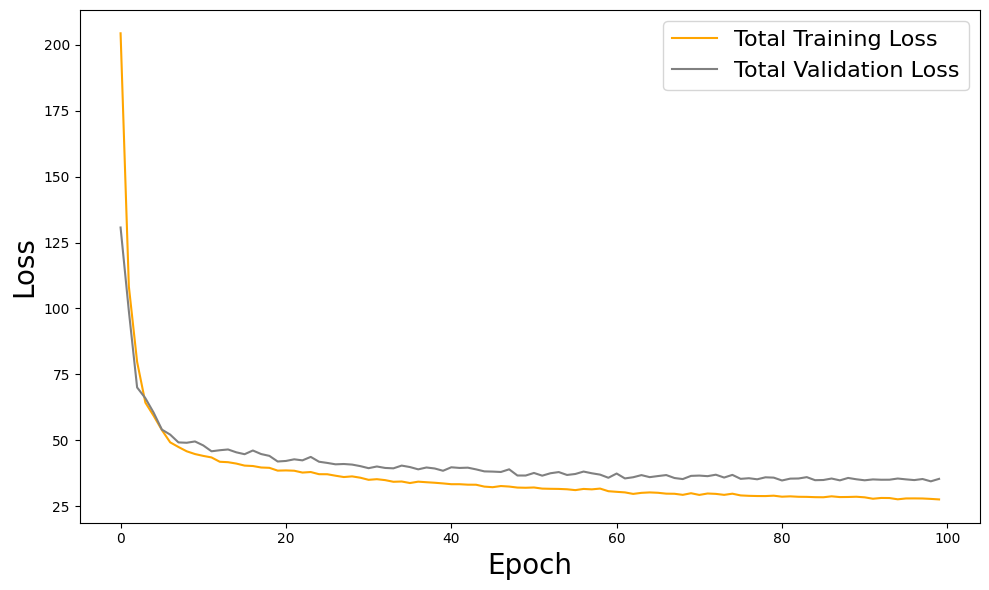

In [38]:
plot_training_validation_loss(avg_total_losses, avg_total_losses_validation)

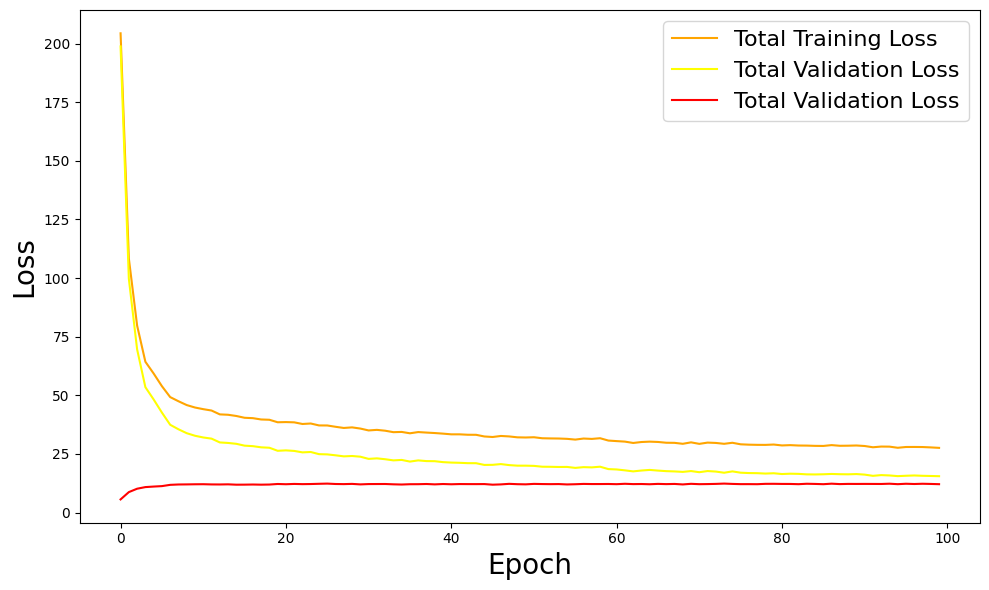

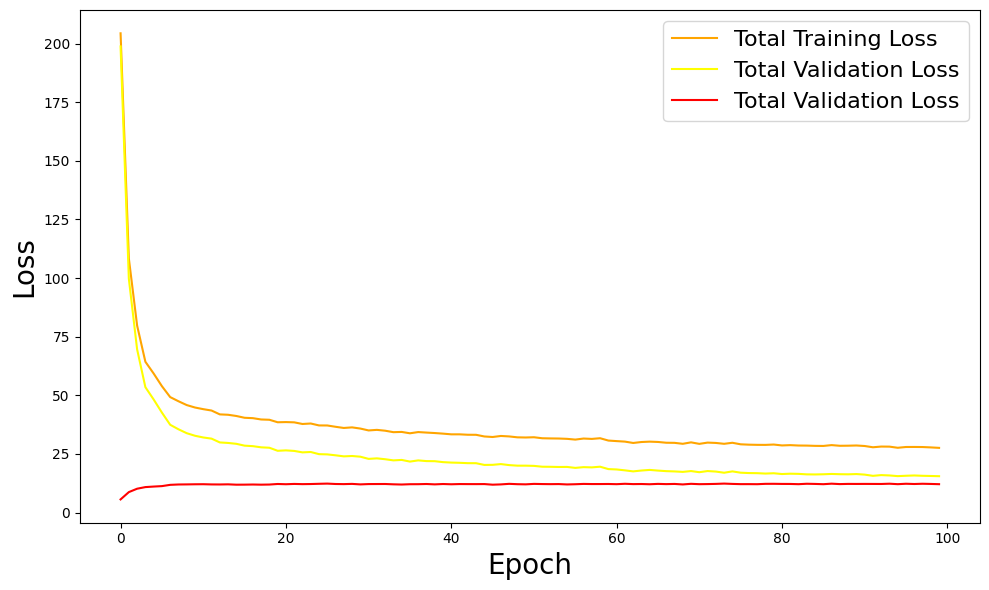

In [39]:
plot_individual_loss(avg_total_losses, avg_reproduction_losses, avg_kld_losses)

### Generated XXXXX Signals

In [40]:
number_of_signals = 10000
noise = torch.randn(number_of_signals, latent_dim).to(DEVICE)

start_time = time.time()
with torch.no_grad():
    generated_signals = model.decoder(noise).cpu().detach().numpy()
end_time = time.time()

execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

Execution Time: 0.22896099090576172 seconds


In [41]:
generated_signals_transpose = np.empty((x_length, 0))

for i in range(number_of_signals):
    y = generated_signals[i, :].flatten()
    y = y * train_dataset.max_value
    y = y.reshape(-1, 1)
    
    generated_signals_transpose = np.concatenate((generated_signals_transpose, y), axis=1)

### Plot Generated Distribution

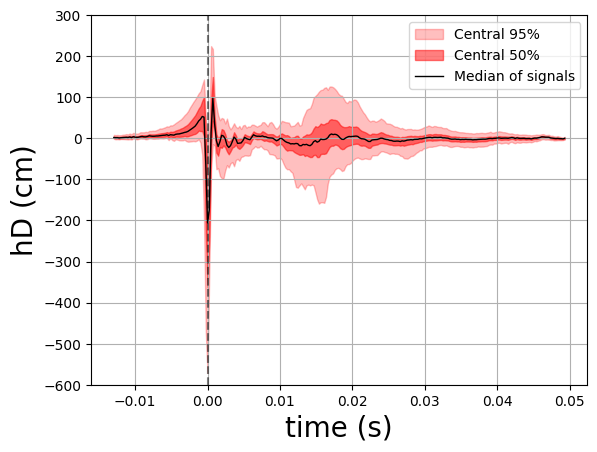

In [42]:
plot_signal_distribution(generated_signals_transpose, generated=True)

### Morph Animation

MovieWriter imagemagick unavailable; using Pillow instead.


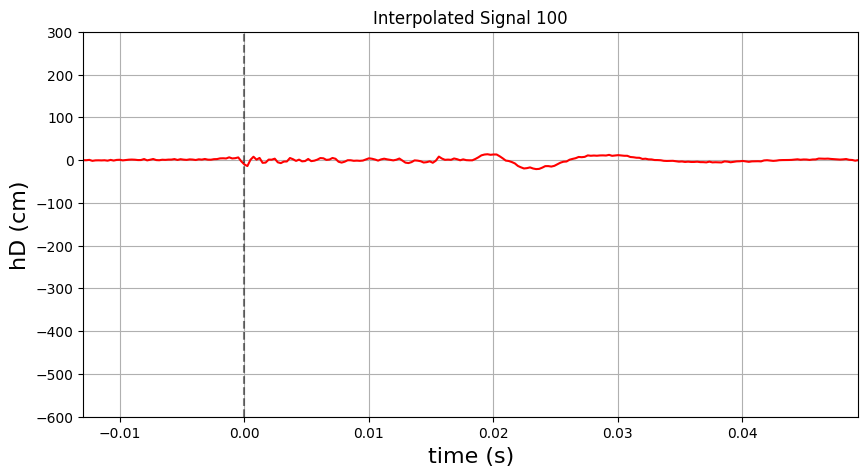

In [47]:
def animate_latent_morphs(
    model: VAE, 
    signal_1: torch.Tensor,
    signal_2: torch.Tensor,
    max_value: float, 
    steps=10,
    interval=200,
    save_path=None
):
    model.eval()

    with torch.no_grad():
        mean_1, _ = model.encoder(signal_1)
        mean_2, _ = model.encoder(signal_2)

        interpolated_latents = [mean_1 * (1 - alpha) + mean_2 * alpha for alpha in np.linspace(0, 1, steps)]
        morphed_signals = [model.decoder(latent).cpu().detach().numpy() for latent in interpolated_latents]

    fig, ax = plt.subplots(figsize=(10, 5))

    # X-axis values (shared across all plots)
    x_vals = [i / 4096 for i in range(0, 256)]
    x_vals = [value - (53 / 4096) for value in x_vals]

    # Initialize the plot
    line, = ax.plot([], [], color="red")
    ax.set_xlim(min(x_vals), max(x_vals))
    ax.set_ylim(-600, 300)
    ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax.grid(True)
    ax.set_xlabel('time (s)', fontsize=16)
    ax.set_ylabel('hD (cm)', fontsize=16)

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        y_interp = morphed_signals[frame].flatten() * max_value
        line.set_data(x_vals, y_interp)
        ax.set_title(f"Interpolated Signal {frame + 1}")
        return line,

    ani = animation.FuncAnimation(fig, update, frames=range(steps), init_func=init, blit=True, interval=interval)

    if save_path:
        ani.save(save_path, writer='imagemagick', fps=30)

    plt.show()

# Example usage
animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, steps=100, interval=200, save_path="morph_animation.gif")

MovieWriter imagemagick unavailable; using Pillow instead.
/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_54023/839517620.py:83: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  moving_point.set_data(latent_point[0], latent_point[1])


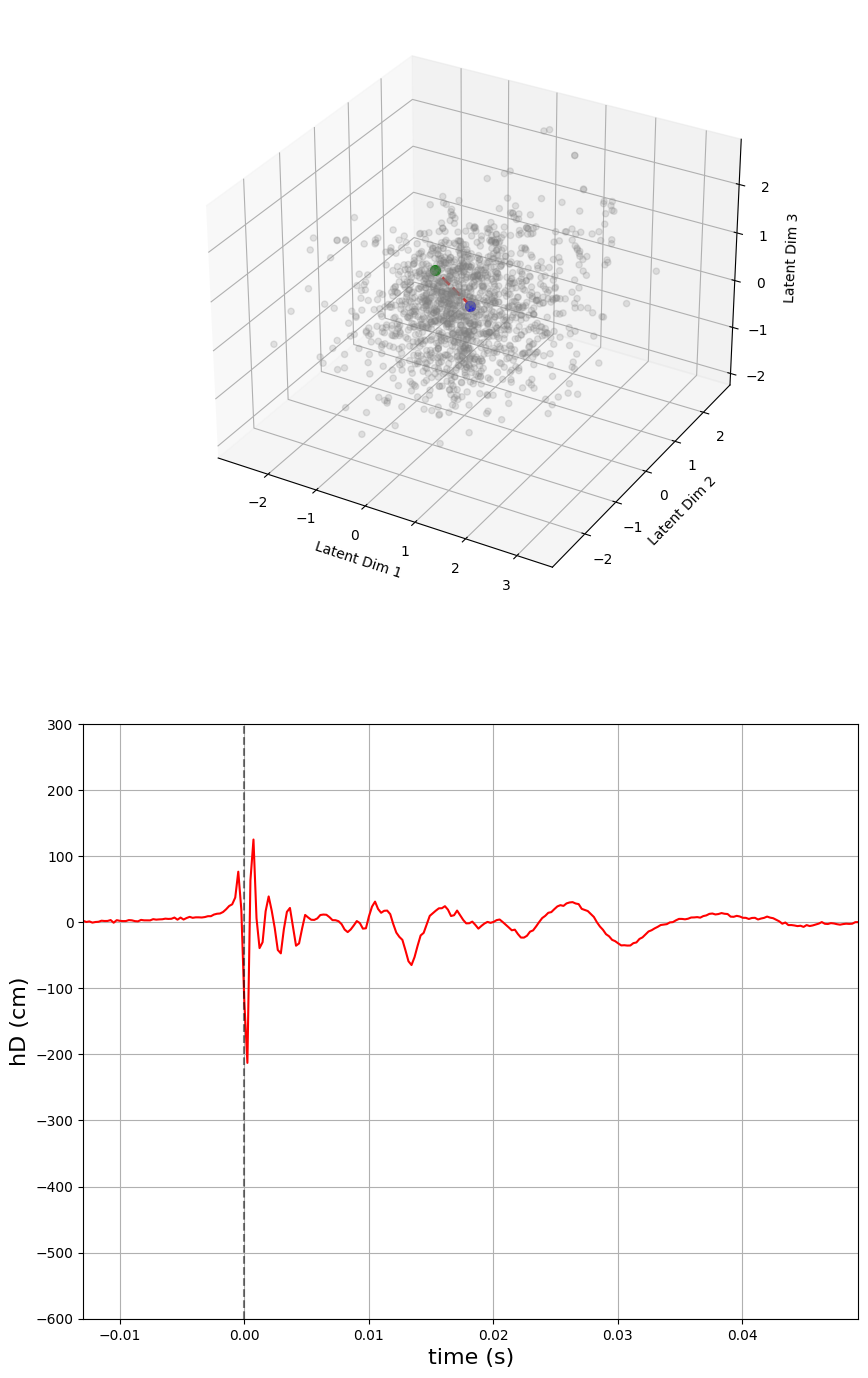

In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

def animate_latent_morphs(
    model,  # Assuming model is a VAE instance
    signal_1: torch.Tensor,
    signal_2: torch.Tensor,
    max_value: float, 
    train_dataset,
    steps=10,
    interval=200,
    save_path=None
):
    model.eval()

    with torch.no_grad():
        mean_1, _ = model.encoder(signal_1)
        mean_2, _ = model.encoder(signal_2)

        # Forward and backward interpolation
        forward_interpolated = [mean_1 * (1 - alpha) + mean_2 * alpha for alpha in np.linspace(0, 1, steps)]
        backward_interpolated = [mean_2 * (1 - alpha) + mean_1 * alpha for alpha in np.linspace(0, 1, steps)]
        interpolated_latents = forward_interpolated + backward_interpolated
        morphed_signals = [model.decoder(latent).cpu().detach().numpy() for latent in interpolated_latents]

        # Compute the posterior distribution
        all_means = []
        for data in train_dataset:
            data = torch.tensor(data).to(model.DEVICE)
            mean, _ = model.encoder(data)
            all_means.append(mean.cpu().numpy())
        all_means = np.concatenate(all_means, axis=0)

    fig = plt.figure(figsize=(10, 17))  # Adjust the figure size for vertical stacking

    # Create 3D plot for latent space
    ax_latent = fig.add_subplot(211, projection='3d')  # First plot (top) in vertical layout
    ax_latent.scatter(all_means[:, 0], all_means[:, 1], all_means[:, 2], color='gray', alpha=0.2, label='Posterior Distribution')
    ax_latent.scatter(mean_1[0].cpu().numpy(), mean_1[1].cpu().numpy(), mean_1[2].cpu().numpy(), color='blue', s=50, label='Signal 1')
    ax_latent.scatter(mean_2[0].cpu().numpy(), mean_2[1].cpu().numpy(), mean_2[2].cpu().numpy(), color='green', s=50, label='Signal 2')
    ax_latent.plot([mean_1[0].cpu().numpy(), mean_2[0].cpu().numpy()],
                   [mean_1[1].cpu().numpy(), mean_2[1].cpu().numpy()],
                   [mean_1[2].cpu().numpy(), mean_2[2].cpu().numpy()], color='red', linestyle='--', label='Interpolation Path', linewidth=2)
    moving_point, = ax_latent.plot([], [], [], 'ro', markersize=7, label='Interpolated Point')
    # ax_latent.set_title('Latent Space Interpolation')
    ax_latent.set_xlabel('Latent Dim 1')
    ax_latent.set_ylabel('Latent Dim 2')
    ax_latent.set_zlabel('Latent Dim 3')
    # ax_latent.legend()

    # Create plot for signal morphing
    ax_signal = fig.add_subplot(212)  # Second plot (bottom) in vertical layout

    # X-axis values (shared across all plots)
    x_vals = [i / 4096 for i in range(0, 256)]
    x_vals = [value - (53 / 4096) for value in x_vals]

    # Initialize the plot
    line, = ax_signal.plot([], [], color="red")
    ax_signal.set_xlim(min(x_vals), max(x_vals))
    ax_signal.set_ylim(-600, 300)
    ax_signal.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax_signal.grid(True)
    ax_signal.set_xlabel('time (s)', fontsize=16)
    ax_signal.set_ylabel('hD (cm)', fontsize=16)

    def init():
        line.set_data([], [])
        moving_point.set_data([], [])
        moving_point.set_3d_properties([])
        return line, moving_point

    def update(frame):
        y_interp = morphed_signals[frame].flatten() * max_value
        line.set_data(x_vals, y_interp)
        # ax_signal.set_title(f"Interpolated Signal {frame + 1}")

        # Update the moving point in the latent space
        latent_point = interpolated_latents[frame].cpu().numpy()
        moving_point.set_data(latent_point[0], latent_point[1])
        moving_point.set_3d_properties(latent_point[2])
        return line, moving_point

    ani = animation.FuncAnimation(fig, update, frames=len(interpolated_latents), init_func=init, blit=True, interval=interval, repeat=True)

    if save_path:
        ani.save(save_path, writer='imagemagick', fps=30)

    plt.show()

# Example usage
animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, train_dataset, steps=100, interval=200, save_path="morph_animation.gif")


### Variational Inference

Replaced 90 synthetic signals with real signals.


/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_54023/3924088266.py:42: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


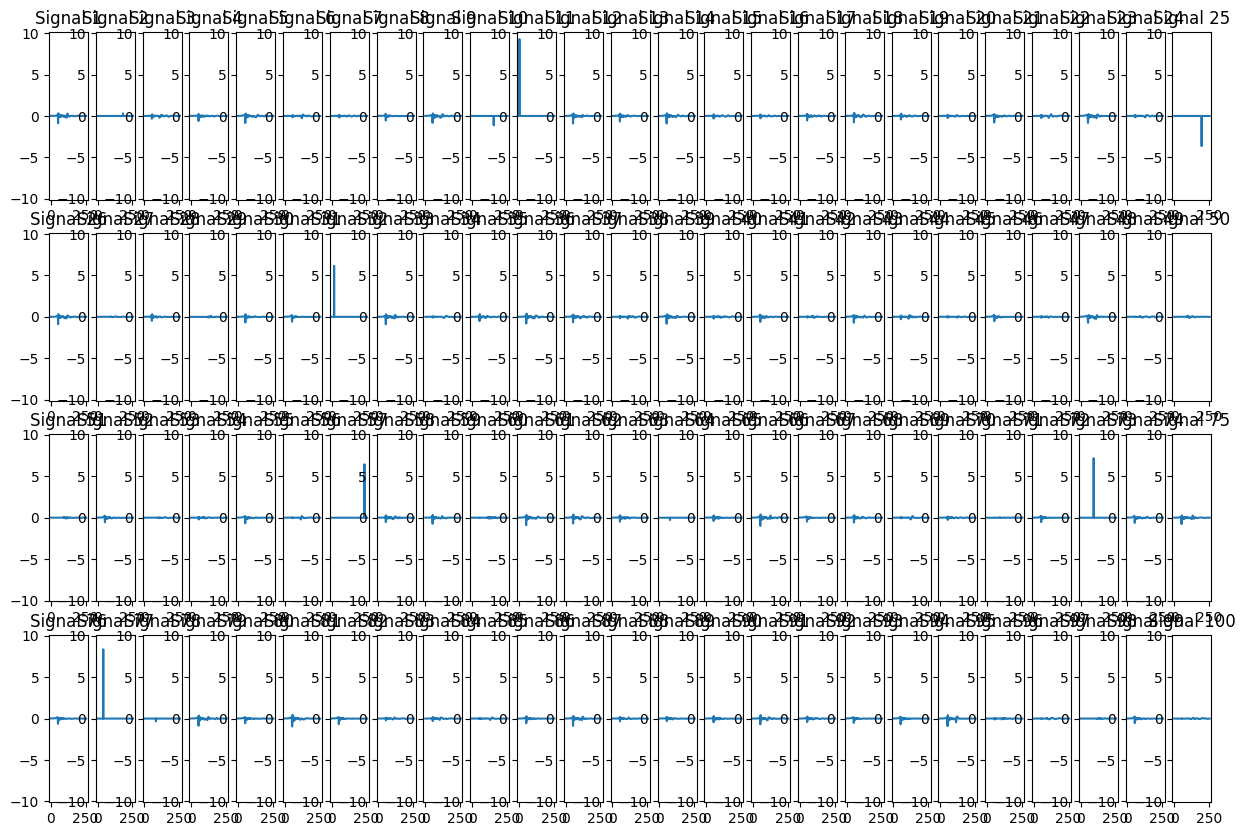

In [75]:
# Parameters
num_signals = 100
signal_length = 256
max_amplitude = 10
min_amplitude = -10

# Generate synthetic signals
signals = np.zeros((num_signals, signal_length))

for i in range(num_signals):
    impulse_position = np.random.randint(0, signal_length)
    impulse_amplitude = np.random.uniform(min_amplitude, max_amplitude)
    signals[i, impulse_position] = impulse_amplitude

# Extract 1-4 real signals from train_dataset DataLoader
num_real_signals = 90
real_signals = []

for i, data in enumerate(train_dataset):
    if i >= num_real_signals:
        break
    if isinstance(data, torch.Tensor):
        real_signals.append(data[0].cpu().numpy().flatten())  # Assuming data is a batch and we take the first element
    else:
        real_signals.append(data[0].flatten())  # If data is already a numpy array

# Replace 1-4 synthetic signals with real signals
replace_indices = np.random.choice(num_signals, num_real_signals, replace=False)
for i, idx in enumerate(replace_indices):
    signals[idx] = real_signals[i]

# Verify the replacement
print(f"Replaced {num_real_signals} synthetic signals with real signals.")

# Plot a few example signals
plt.figure(figsize=(15, 10))
for i in range(100):
    plt.subplot(4, 25, i + 1)
    plt.plot(signals[i])
    plt.ylim(min_amplitude - 0.1, max_amplitude + 0.1)
    plt.title(f'Signal {i + 1}')
plt.tight_layout()
plt.show()

In [45]:
import torch
import torch.nn.functional as F
from typing import List

def compute_marginal_likelihood(model, data, device):
    model.eval()
    log_likelihoods = []

    signals_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    with torch.no_grad():
        for x in signals_tensor:
            x = x.to(device)
            x_hat, mean, log_var = model(x)
            recon_loss = F.mse_loss(x_hat, x, reduction='sum')
            kld_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
            log_likelihood = -(recon_loss + kld_loss).item()
            log_likelihoods.append(log_likelihood)

    return log_likelihoods

def plot_marginal_likelihood(
    log_likelihoods: List[float],
    fname: str = None,
    axes: plt.Axes = None,
):
    if axes is None:
        fig = plt.figure(figsize=(10, 6))
        axes = fig.gca()
    axes.plot(log_likelihoods, label="Marginal Likelihood")
    axes.set_xlabel("Batch", size=20)
    axes.set_ylabel("Log Likelihood", size=20)
    axes.legend(fontsize=16)
    
    plt.tight_layout()

    if fname:
        plt.savefig(fname)
    
    return axes.get_figure()

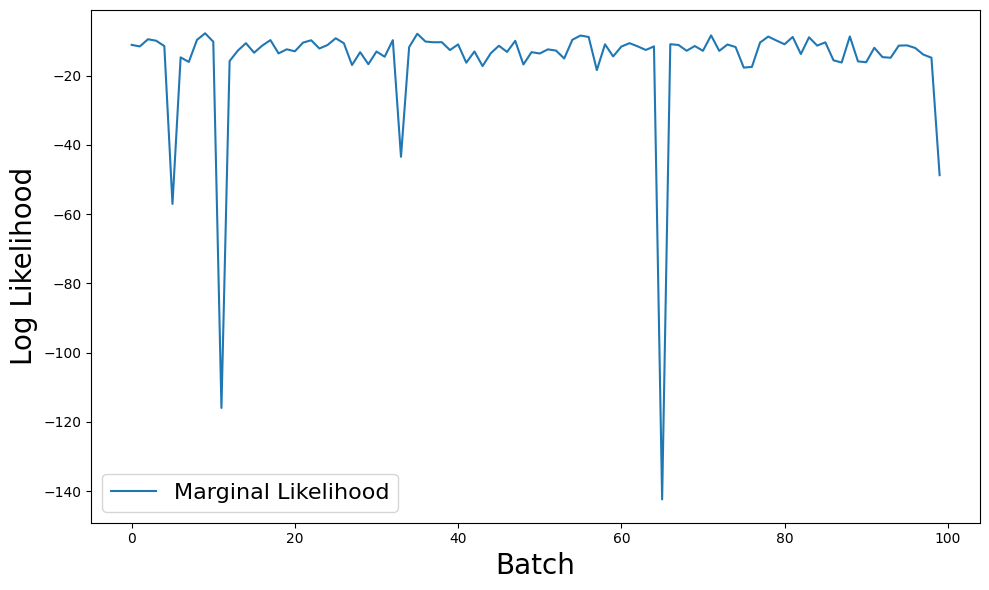

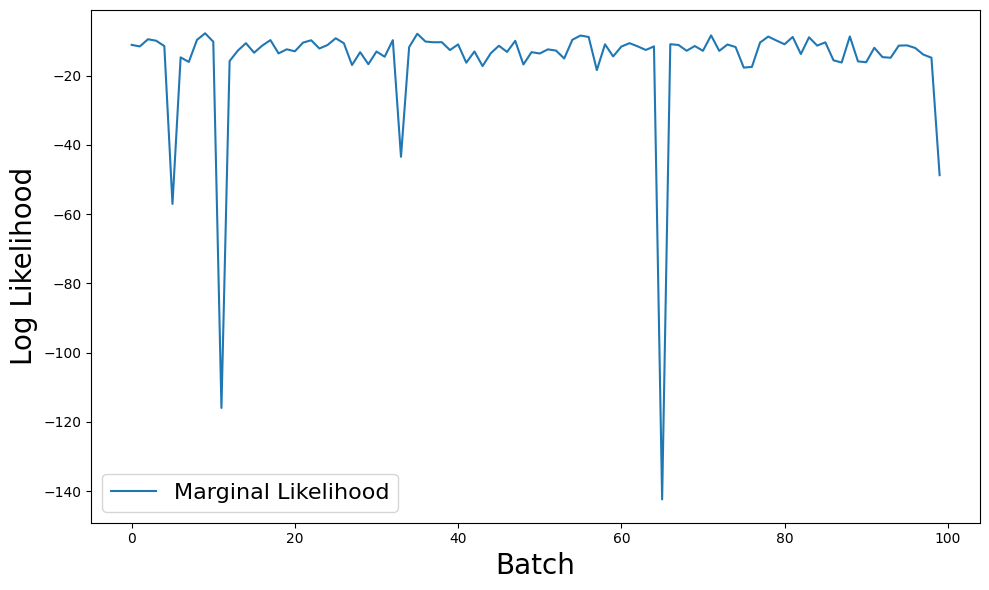

In [46]:
log_likelihoods = compute_marginal_likelihood(model, signals, DEVICE)
plot_marginal_likelihood(log_likelihoods)